# Explore order MEMs

In [1]:
from random import randint
import pandas as pd
import numpy as np
from collections import Counter


In [2]:
# import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches
%matplotlib inline

plt.rcParams['figure.dpi'] = 300
plt.style.use('BME163')


In [3]:
# https://github.com/ponnhide/patchworklib
import patchworklib as pw

import plotnine as p9
p9.__version__ = '0.9.0'

<Figure size 300x300 with 0 Axes>

In [148]:
# import plotnine
from plotnine import \
    ggplot, aes, theme, themes, element_blank, element_line, element_text, mapping, \
    geom_point, geom_jitter, geom_line, geom_bar, geom_boxplot, geom_violin, geom_histogram, \
    ggtitle, xlab, ylab, geom_vline, geom_hline, geom_col, \
    scale_x_discrete, scale_y_discrete, scale_x_continuous, scale_y_continuous, \
    scale_color_discrete, scale_fill_manual, scale_fill_hue, scale_fill_gradient, scale_color_manual, scale_color_hue, \
    guides, \
    xlim, ylim
from plotnine.options import figure_size


# plotnine theme
def theme_tufte_func(base_size=19, base_family="sans", rotate=True, figure_size=None):
    ''' Plotnine plotting theme. '''
    thm = themes.theme_bw(base_size=base_size, base_family = base_family) + \
        theme(
            legend_background = element_blank(),
            legend_key = element_blank(),
            panel_background = element_blank(),
            panel_border = element_blank(),
            strip_background = element_blank(),
            plot_background = element_blank(),
            panel_grid = element_blank(),
            axis_line = element_line(colour = "black", size = 1),
            axis_text_y = element_text(colour = "black")
        )

    if rotate:
        thm += theme(axis_text_x=element_text(rotation=45, hjust=1))
    if figure_size is not None:
        thm += theme(figure_size=figure_size)
    return thm


# Assorted helper functions

In [5]:
# Reading a file
def fileReader(path):
    ''' Read file from path line-by-line. '''
    with open(path, 'r') as inFile:
        for line in inFile:
            yield line.strip()


In [6]:
def parse_dap(dap_line):
    '''
    position, document_array
    [3,       65535, 13, 13, 13, 12]
    '''
    pos, *doc_array = map(int, dap_line.split(' '))
    doc_array.sort(reverse=True)
    return pos, doc_array


In [7]:
def findMEMs(a):
    lm = np.r_[a[:-1] >= a[1:], True]
    return lm

In [8]:
def print_mem_doc_query(header, start_idx, end_idx):
    l = []
    row_idxs = list(range(start_idx, end_idx))

    # skip to start_idx:
    curr_start_idx, *doc_array = parse_dap(next(dap_stream)) # first_row
    curr_start_idx = int(curr_start_idx)

    if curr_start_idx > start_idx:
        print(curr_start_idx, start_idx)
        print(type(curr_start_idx), type(start_idx))
        raise Exception('Start index error')   # stream should start less or equal to desired index

    while curr_start_idx < start_idx:
        curr_start_idx, *doc_array = parse_dap(next(dap_stream)) # first_row

    # add first entry
    l.append(doc_array[0])

    # parse rest of the entries
    for row in row_idxs[1:]:
        l.append(parse_dap(next(dap_stream))[1])
    num_docs = len(l[0])
    ar = np.array(l)

    # print and print format to bed
    for doc in range(1,num_docs):
        doc_array = ar[:,doc]
        MEM_start = np.array(row_idxs)[findMEMs(doc_array)]
        MEM_lens = doc_array[findMEMs(doc_array)]
        MEM_end = MEM_start + MEM_lens
        print(*['\t'.join([header, *map(str, [i, j, doc])]) for i, j in zip(MEM_start, MEM_end) ], sep='\n')


In [9]:
file_fai_path = '/home/stephen/Documents/projects/langmead_lab/analysis/order_mems/bacteria_5/e_coli_pivot/input.fna.fai'
fai_stream = fileReader(file_fai_path)

interval_list = []
for row in fai_stream:
    chrm, length, *_ = row.split()
    interval_list.append((chrm, int(length)))

interval_df = pd.DataFrame(interval_list, columns=('chrm', 'length'))
interval_df['end'] = interval_df['length'].cumsum()
interval_df['start'] = interval_df['end'] - interval_df['length']

# e coli pivot
query = ['NZ_CP015023.1', 'NZ_CP015022.1']
query_interval_df = interval_df[list(map(lambda _ : _ in query, interval_df['chrm']))]
query_intervals = list(zip(query, zip(query_interval_df['start'], query_interval_df['end'])   )  )
query_intervals

NameError: name 'fileReader' is not defined

In [ ]:
#dap_path = '/home/stephen/Documents/projects/langmead_lab/analysis/order_mems/bacteria_5/e_coli_pivot/tmp.txt'
#dap_stream  = fileReader(dap_path)
#print_mem_doc_query( 'head', *(0, 20) )
#print()
#print_mem_doc_query( *(25, 35) )
#print()
#print_mem_doc_query( *(35, 42) )

In [104]:
# file path
dap_path = '/home/stephen/Documents/projects/langmead_lab/analysis/order_mems/bacteria_5/e_coli_pivot/full_dap.txt'
dap_stream  = fileReader(dap_path)

# ('NZ_CP015023.1', (0, 5506801))
header, start_stop = query_intervals[0]
print_mem_doc_query(header, *start_stop)

# ('NZ_CP015022.1', (11013602, 11108772))
header, start_stop = query_intervals[1]
print_mem_doc_query(header, *start_stop)


KeyboardInterrupt: 

# Explore MEM overlap sizes

In [97]:
from scipy.stats import mode
from scipy.stats import hmean


In [380]:
MEM_overlap_bed_path = '/home/stephen/Documents/projects/langmead_lab/analysis/order_mems/bacteria_5/e_coli_pivot/plot_mem_overlaps/k12_data/order_mem_overlaps.bed'
bedList = pd.read_csv(MEM_overlap_bed_path, sep='\t', header=None, names=['chrm', 'start', 'end', 'order']).values.tolist()
bedList[:10]

[['NZ_CP015023.1', 1, 10, 3],
 ['NZ_CP015023.1', 1, 10, 4],
 ['NZ_CP015023.1', 1, 11, 1],
 ['NZ_CP015023.1', 2, 11, 2],
 ['NZ_CP015023.1', 2, 11, 3],
 ['NZ_CP015023.1', 2, 11, 4],
 ['NZ_CP015023.1', 2, 12, 1],
 ['NZ_CP015023.1', 3, 12, 4],
 ['NZ_CP015023.1', 5, 16, 1],
 ['NZ_CP015023.1', 6, 15, 4]]

In [434]:
orders = list(range(1,5))
order_dict = {order:[] for order in orders}

for bed in bedList:
    chromosome, start, end, order = bed
    order_dict[order].append(end-start)

print('\nMax:')
for order, order_val in order_dict.items():
    print(order, max(order_val))

print('\nMin:')
for order, order_val in order_dict.items():
    print(order, min(order_val))

print('\nModes:')
for order, order_val in order_dict.items():
    print(order, int(mode(order_val)[0]))

print('\nMean:')
for order, order_val in order_dict.items():
    print(order, np.mean(order_val))

print('\nHarmonic mean:')
for order, order_val in order_dict.items():
    print(order, hmean(order_val))



Max:
1 1030
2 581
3 313
4 88

Min:
1 7
2 7
3 6
4 6

Modes:
1 11
2 11
3 10
4 10

Mean:
1 11.692319223136739
2 10.830877928342453
3 10.553475746265718
4 9.92655896910797

Harmonic mean:
1 11.135941747397306
2 10.708385252718294
3 10.451444692181283
4 9.84688027846561


In [435]:
# plot distribution of MEM overlaps
n_samples=10_000

v_list = []
for order, order_vals in order_dict.items():
    for order_val in order_vals:
        v_list.append([order_val, order])

filtered_bedlist_df = pd.DataFrame(v_list, columns=['length','Order'])
filtered_bedlist_df['Order'] = pd.Categorical(filtered_bedlist_df['Order'],
                                              categories=list(set(filtered_bedlist_df['Order']))[::-1])

# calcualte mode
order_mode_label = {}
for order, order_val in order_dict.items():
    val = int(mode(order_val)[0])
    order_mode_label[order] = str(order) + ' (mode=' + str(val) + ')'


In [436]:
# prepare plotting data
data = filtered_bedlist_df.sample(n=n_samples)
data['Order'] = list(map(order_mode_label.get, data['Order']))


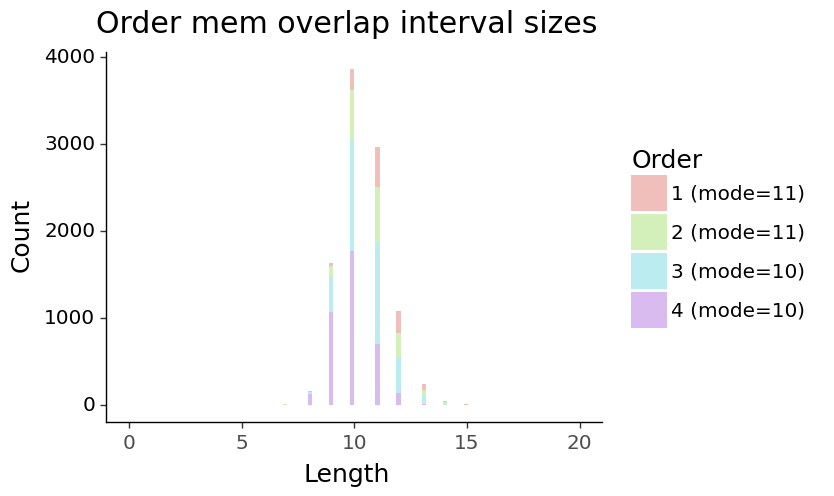

<ggplot: (8761045273191)>

In [437]:
# Plot distribution of lengths of order mem overlaps (subsampled)


(
    ggplot(data, aes(x='length', fill='Order')) +
    geom_histogram(position='stack', alpha=0.4) +
    xlim([0,20]) +
    ggtitle("Order mem overlap interval sizes") +
    xlab("Length") +
    ylab("Count") +
    theme_tufte_func(base_size=18, rotate=False)
)


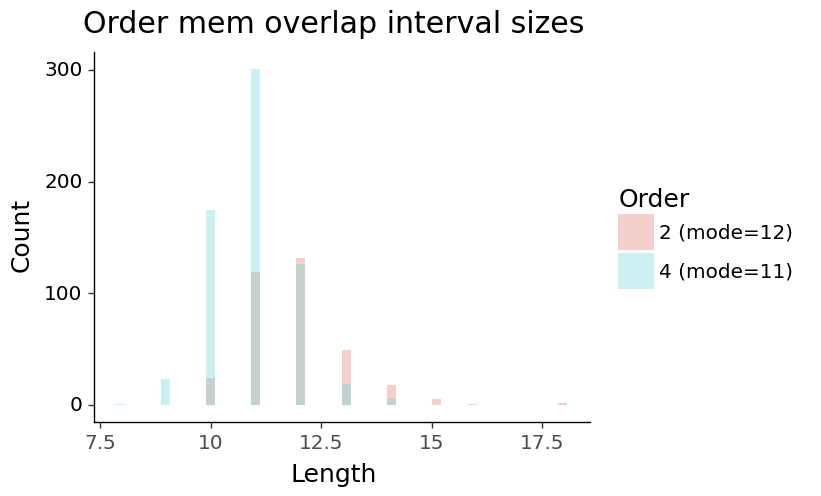

<ggplot: (8761042268136)>

In [432]:
plot_orders = {2,4}

(
    ggplot(data[list(map(lambda x : int(x[0]) in plot_orders, data['Order']))].sample(n=1000), aes(x='length', fill='Order')) +
    geom_histogram(position='identity', alpha=0.3) +
    #geom_histogram(position='stack', alpha=0.3) +
    ggtitle("Order mem overlap interval sizes") +
    xlab("Length") +
    ylab("Count") +
    theme_tufte_func(base_size=18, rotate=False)
)

# Plotting the Overlap MEMs directly

In [9]:
num_docs = 4
colors = ['#d7301f', '#fc8d59', '#fdcc8a', '#fef0d9']
color_dict = dict(zip(range(1,1+num_docs), colors))

target = ['NZ_CP015023.1', 0, 1000]        # target region
#target = ['NZ_CP015023.1', 0, 5000]        # target region
#target = ['NZ_CP015023.1', readList2[0][1], readList2[-1][2]]        # target region
#target = ['NZ_CP015023.1', readList2[0][1], int(readList2[-1][2]/4)]        # target region
buffer = 25                                   # buffer to plot


genome_size = 5506800
target = ['NZ_CP015023.1', 0, int(genome_size/4)]        # target region


In [7]:

width = 0.75
bottom_y = 0.5
order_to_y_pos = {
    1 : bottom_y,
    2 : bottom_y + width * 1 ,
    3 : bottom_y + width * 2,
    4 : bottom_y + width * 3
}

def plotMEMs(panel, readList, target):
    genome_chromosome, genome_start, genome_end = target
    filtered_readlist = []
    for read in readList:
        chromosome, start, end, order = read
        if (chromosome == genome_chromosome) and (genome_start <= start <= genome_end or genome_start <= end <= genome_end):
            color = color_dict[order]
            rectangle1 = mplpatches.Rectangle((start, order_to_y_pos[order]),
                                                end - start,
                                                0.5,
                                                facecolor=color,
                                                edgecolor=color,
                                                linewidth=0)
            panel.add_patch(rectangle1)
    return order_to_y_pos[4]


KeyboardInterrupt: 

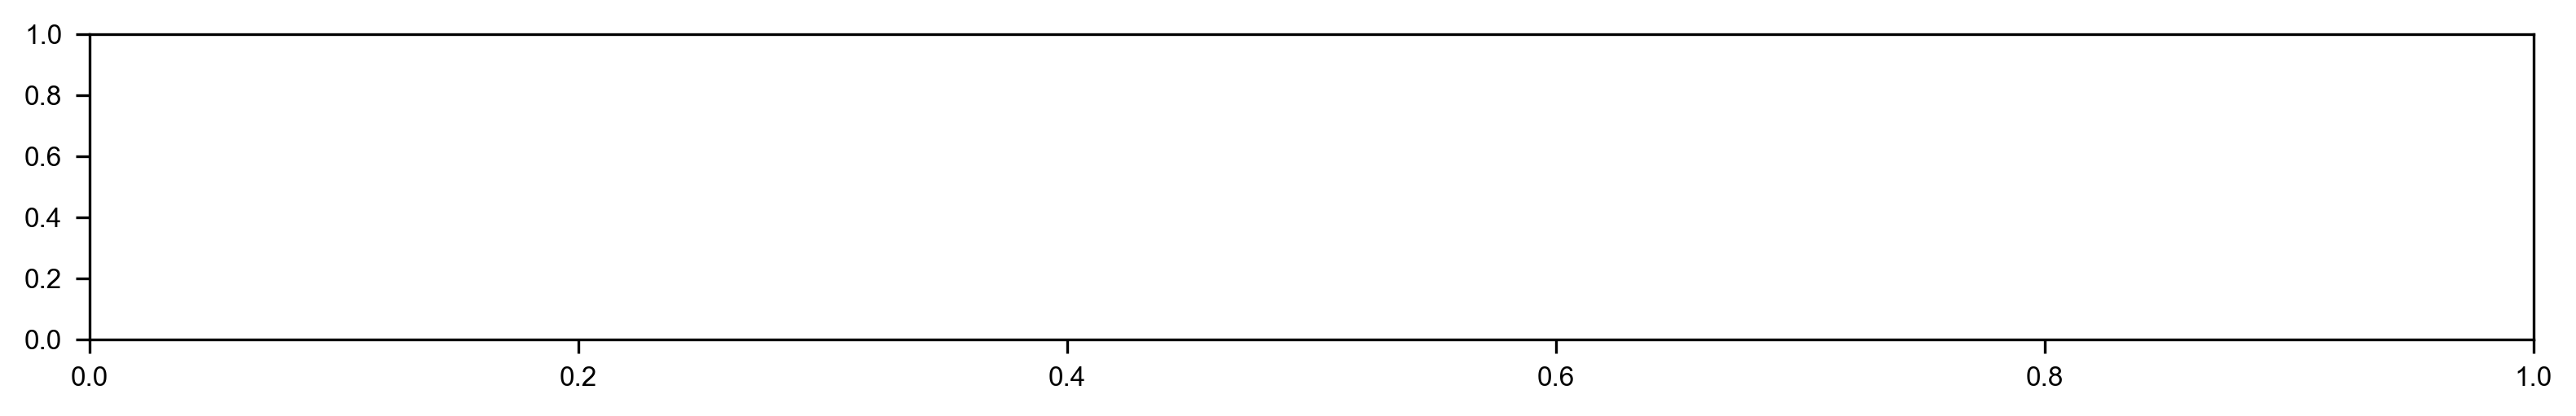

In [10]:
# Download data
# Overlap MEMs
#MEM_bed_path = '/home/stephen/Documents/projects/langmead_lab/analysis/order_mems/bacteria_5/e_coli_pivot/plot_mem_overlaps/k12_data/order_mem_overlaps.bed'
#MEM_bed_path = '/home/stephen/Documents/projects/langmead_lab/analysis/order_mems/bacteria_5/e_coli_pivot/plot_mem_overlaps/k12_data/pre_merged_ordered_mems.bed'

#MEM_bed_path = '/home/stephen/Documents/projects/langmead_lab/analysis/order_mems/bacteria_5/e_coli_pivot/plot_mem_overlaps/k12_data/order_mem_unique_k12.bed'

MEM_bed_path = '/home/stephen/Documents/projects/langmead_lab/omem/workflow/results/omem_12mer.bed'
MEM_bed_path = '/home/stephen/Documents/projects/langmead_lab/omem/data/triangle_intervals/order_mem_overlaps.bed'
mem_bed = pd.read_csv(MEM_bed_path, sep='\t', header=None, names=['chrm', 'start', 'end', 'order'])
readList = mem_bed.values.tolist()


# Figure parameters
figureWidth = 10
figureHeight = 5
panelHeight = 1.25
panelWidth = 10
relativePanelWidth = panelWidth / figureWidth
relativePanelHeight = panelHeight / figureHeight
plt.figure(figsize=(figureWidth, figureHeight))
panel = plt.axes([0, 0.05, relativePanelWidth, relativePanelHeight])

#############################################################################
# plot region
mem_plot = plotMEMs(panel, readList, target)

#############################################################################
# adjust panel
buffer = 25
panel.set_xlim(target[1] - buffer, target[2] + buffer)
panel.set_ylim(0, mem_plot + 1)

panel.tick_params(bottom=True,
                  labelbottom=True,
                  left=False,
                  labelleft=False,
                  right=False,
                  labelright=False,
                  top=False,
                  labeltop=False)
panel.set_xlabel('Position')
#panel.set_title("Order MEM k-casted intervals (k=12)") #:\n" + target[0] + ':' + str(target[1]) + '-' + str(target[2]))
panel.set_title("Order MEM k-casted intervals (k=12)") #:\n" + target[0] + ':' + str(target[1]) + '-' + str(target[2]))
#panel.set_title("Order MEM shadow intervals (k=12, unmerged):\n" + target[0] + ':' + str(target[1]) + '-' + str(target[2]))
#panel.set_title("Order MEM overlaps:\n" + target[0] + ':' + str(target[1]) + '-' + str(target[2]))

plt.show()
#outputFile = '/home/stephen/Documents/projects/langmead_lab/analysis/order_mems/bacteria_5/e_coli_pivot/plot_mem_overlaps/tmp_2.png'
#plt.savefig(outputFile, dpi=600)


# From MEM shadow intervals to panagram visual

In [6]:
#MEM_bed_path = '/home/stephen/Documents/projects/langmead_lab/analysis/order_mems/bacteria_5/e_coli_pivot/plot_mem_overlaps/k12_data/order_mem_unique_k12.bed'

bed_dir = '/home/stephen/Documents/projects/langmead_lab/analysis/order_mems/bacteria_5/e_coli_pivot/plot_mem_overlaps/test_sort/'
#MEM_bed_path = bed_dir + 'omem_12mer.bed'
MEM_bed_path = bed_dir + 'no_sort.bed'

mem_bed = pd.read_csv(MEM_bed_path, sep='\t', header=None, names=['chrm', 'start', 'end', 'order'])
k=12

In [7]:
# from MEM shadow intervals to panagram visual

positions = list(mem_bed.index)
num_orders = len(set(mem_bed['order']))
mem_bed_order_matrix = np.zeros((num_orders+1, len(positions)))

for order in range(num_orders):
    mem_bed_order_subset = mem_bed[mem_bed['order'] == order+1]
    for start, end in zip(mem_bed_order_subset['start'], mem_bed_order_subset['end']):
        mem_bed_order_matrix[order, start:end] = 1
mem_bed_order_matrix[order+1,:] = 1

num_docs_per_pos = np.argmax(mem_bed_order_matrix, axis=0)
num_docs_per_pos

array([0, 0, 3, ..., 3, 3, 2])

In [12]:
len(list(num_docs_per_pos))

1840679

## HERE

In [188]:
num_docs_per_pos = list(map(int, list(fileReader('/home/stephen/Documents/projects/langmead_lab/omem/analysis/data/memo_hla_conservation.out'))))

In [189]:
positions = len(num_docs_per_pos)

In [190]:
n_bins = 350*2

per_bin_doc_composition_list = []
bin_space = list(map(int,np.linspace(0, positions, n_bins)))

for bin_idx, start_end in enumerate(list(zip(bin_space[:-1], bin_space[1:]))):
    bin_start, bin_end = start_end
    doc_count_per_order_in_bin = Counter(num_docs_per_pos[bin_start : bin_end])
    #normalized_doc_count_per_order_in_bin = [(order, cnt/sum(doc_count_per_order_in_bin.values())) for order, cnt in doc_count_per_order_in_bin.items()]
    normalized_doc_count_per_order_in_bin = [(order, doc_count_per_order_in_bin[order]/sum(doc_count_per_order_in_bin.values())) for order in range(90) ]
    normalized_doc_count_per_order_in_bin_in_sorted_order_mem_order = sorted(normalized_doc_count_per_order_in_bin, key=lambda x: x[0])   # sorting by order
    per_bin_doc_composition_list.append([bin_idx]+[norm_cnt[1] for norm_cnt in normalized_doc_count_per_order_in_bin_in_sorted_order_mem_order])

cnames = ['pos'] + list(range(90))
per_bin_doc_composition_df = pd.DataFrame(per_bin_doc_composition_list, columns=cnames)

per_bin_doc_composition_df = pd.melt(per_bin_doc_composition_df, id_vars=['pos'], value_vars=cnames[1:])
per_bin_doc_composition_df.columns = ['bin','Num docs','value']

per_bin_doc_composition_df['Num docs'] = pd.Categorical(per_bin_doc_composition_df['Num docs'], categories=cnames[:0:-1])
per_bin_doc_composition_df

,bin,Num docs,value
0,0,0,0.000000
1,1,0,0.000000
2,2,0,0.000000
3,3,0,0.000000
4,4,0,0.000000
...,...,...,...
62905,694,89,0.884379
62906,695,89,0.844163
62907,696,89,0.880469
62908,697,89,0.873953


In [191]:


np.linspace(29476949, 33231258, 7)

array([29476949.        , 30102667.16666667, 30728385.33333333,
       31354103.5       , 31979821.66666667, 32605539.83333333,
       33231258.        ])

In [192]:
?df.astype()

Object `df.astype()` not found.


In [193]:
list(range(0,701,100))

[0, 100, 200, 300, 400, 500, 600, 700]

In [220]:
per_bin_doc_composition_df['Num.\nGenomes'] = per_bin_doc_composition_df['Num docs'].astype('float64')
per_bin_doc_composition_df

,bin,Num docs,value,Number Genomes,Num. Genomes,Num.\nGenomes
0,0,0,0.000000,0.0,0.0,0.0
1,1,0,0.000000,0.0,0.0,0.0
2,2,0,0.000000,0.0,0.0,0.0
3,3,0,0.000000,0.0,0.0,0.0
4,4,0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...
62905,694,89,0.884379,89.0,89.0,89.0
62906,695,89,0.844163,89.0,89.0,89.0
62907,696,89,0.880469,89.0,89.0,89.0
62908,697,89,0.873953,89.0,89.0,89.0


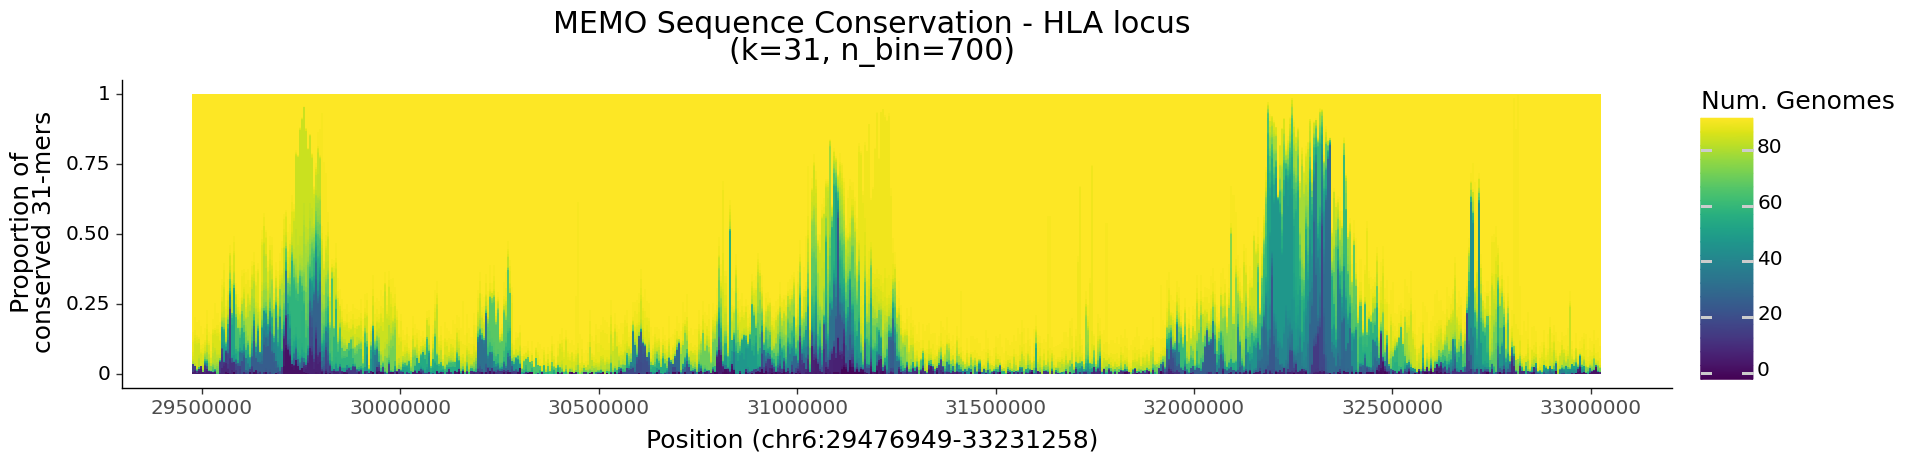

<ggplot: (8791281733021)>

In [230]:
data = per_bin_doc_composition_df

# plot MEM-version of Panagram
(
    ggplot(data, aes(x='bin', y='value', fill='Num. Genomes')) +
    geom_bar(stat="identity", width=1) +
    ggtitle("MEMO Sequence Conservation - HLA locus\n(k=31, n_bin=700)") +
    xlab("Position (chr6:29476949-33231258)") +
    ylab("Proportion of\nconserved 31-mers") +
    scale_x_continuous(
        breaks=np.linspace(0+4.297913597971398, 699-5.828128204650122, 8),
        labels=list(range(29_500_000, 33_200_000, 500_000))) +
    theme_tufte_func(base_size=18, rotate=False, figure_size=[20,4]) #+
    #theme(legend_title = element_text(size = 13))
)


In [207]:
#split
#29476949-33231258 into 7 

np.linspace(29_500_000, 33_200_000, 7)


array([29500000.        , 30116666.66666667, 30733333.33333333,
       31350000.        , 31966666.66666667, 32583333.33333333,
       33200000.        ])

In [209]:
29476949 - 29_500_000

-23051

In [208]:
33231258 - 33_200_000

31258

In [212]:
(33231258 - 29476949) / 700
# each bin is equal to 5363.30 bp

5363.298571428571

In [213]:
23051 / 5363.30

4.297913597971398

In [214]:
31258 / 5363.30

5.828128204650122

In [217]:
np.linspace(0+4.297913597971398, 699-5.828128204650122, 7)



array([  4.2979136 , 119.11023996, 233.92256633, 348.7348927 ,
       463.54721906, 578.35954543, 693.1718718 ])

In [205]:
list(range(29_500_000, 33_200_000, 500_000))

[29500000,
 30000000,
 30500000,
 31000000,
 31500000,
 32000000,
 32500000,
 33000000]

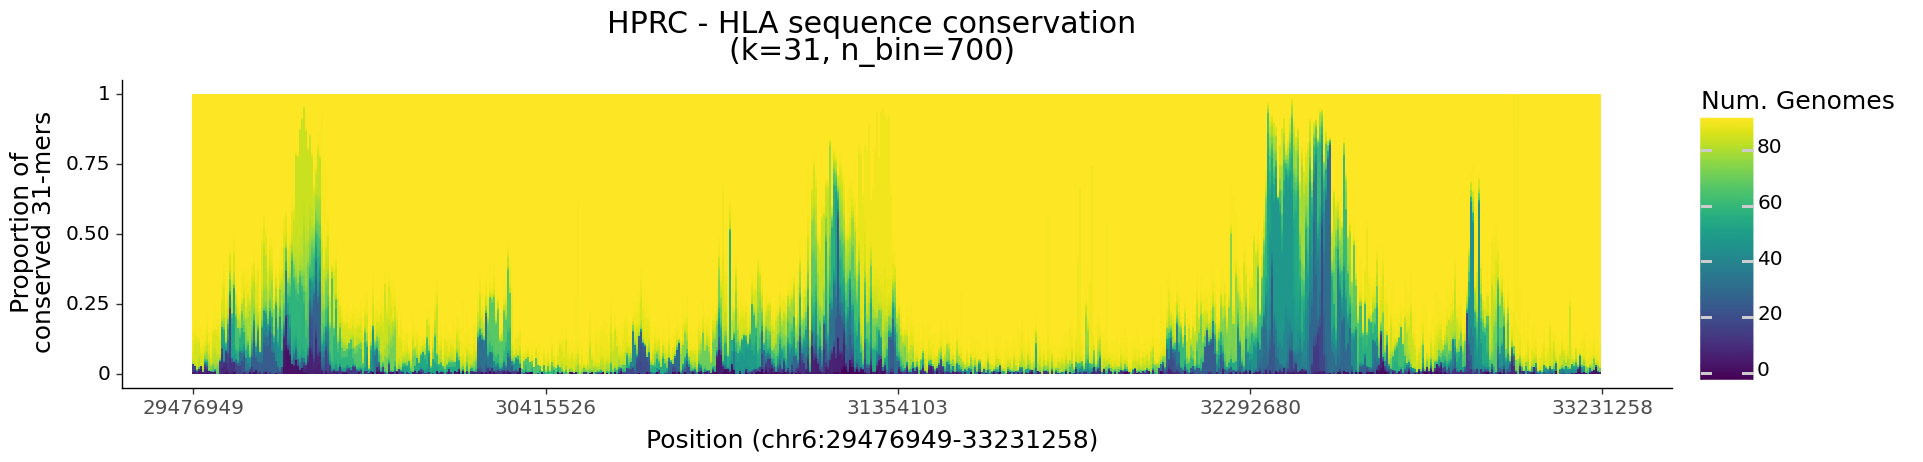

<ggplot: (8791278076603)>

In [199]:
data = per_bin_doc_composition_df

# plot MEM-version of Panagram
(
    ggplot(data, aes(x='bin', y='value', fill='Num. Genomes')) +
    geom_bar(stat="identity", width=1) +
    ggtitle("HPRC - HLA sequence conservation\n(k=31, n_bin=700)") +
    xlab("Position (chr6:29476949-33231258)") +
    ylab("Proportion of\nconserved 31-mers") +
    scale_x_continuous(breaks=np.linspace(0,699,5),
                       labels=list(map(int,np.linspace(29476949, 33231258, 5)))) +
    theme_tufte_func(base_size=18, rotate=False, figure_size=[20,4])
)


In [156]:
?scale_x_continuous

Init signature: scale_x_discrete(*args, **kwargs)
Docstring:     
Discrete x position

Parameters
----------
breaks : array_like or callable, optional
    Major break points. Alternatively, a callable that
    takes a tuple of limits and returns a list of breaks.
    Default is to automatically calculate the breaks.
expand : tuple, optional
    Multiplicative and additive expansion constants
    that determine how the scale is expanded. If
    specified must be of length 2 or 4. Specifically the
    values are in this order::

        (mul, add)
        (mul_low, add_low, mul_high, add_high)

    For example,

        - ``(0, 0)`` - Do not expand.
        - ``(0, 1)`` - Expand lower and upper limits by 1 unit.
        - ``(1, 0)`` - Expand lower and upper limits by 100%.
        - ``(0, 0, 0, 0)`` - Do not expand, as ``(0, 0)``.
        - ``(0, 0, 0, 1)`` - Expand upper limit by 1 unit.
        - ``(0, 1, 0.1, 0)`` - Expand lower limit by 1 unit and
          upper limit by 10%.
      

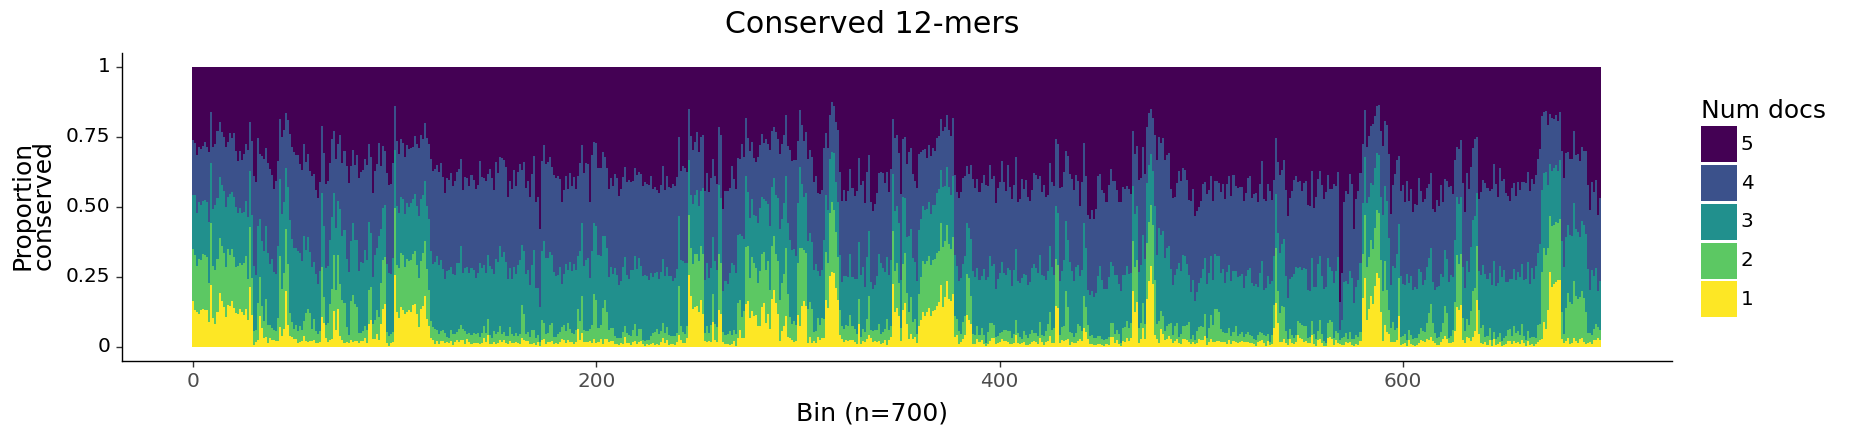

<ggplot: (8781317489405)>

In [49]:
data = per_bin_doc_composition_df

# plot MEM-version of Panagram
panagram_colors = ['#440154', '#3b518b', '#21908d', '#5cc863', '#fde725']
(
    ggplot(data, aes(x='bin', y='value', fill='Num docs')) +
    geom_bar(stat="identity", width=1) +
    ggtitle("Conserved " + str(k) + '-mers') +
    xlab("Bin (n=" + str(n_bins) +')') +
    ylab("Proportion\nconserved") +
    scale_fill_manual(panagram_colors) +
    theme_tufte_func(base_size=18, rotate=False, figure_size=[20,4])
)


# Plotly 

In [17]:
from dash import Dash, dcc, html, Input, Output
import subprocess
import plotly.graph_objects as go
import numpy as np


In [22]:
n_bins = 350*2
num_docs = 4
k = 12
colors = ['#fde725', '#5cc863', '#21908d', '#3b518b', '#440154']


In [92]:

def call_query(k):
    cmd = [
        "/home/stephen/Documents/projects/langmead_lab/omem/src/query.sh",
        "-k", str(k),
        "-n", "4",
        "-o", "/home/stephen/Documents/projects/langmead_lab/omem/data/example_dap",
        "-b", "omem.bed.gz",
        "-r", "NZ_CP015023.1:0-5506800",
        #"-i",
        #"-r", "omem_overlaps.bed",
        "-p"
        ]
    subprocess.check_call(cmd)
    return 1


def update_data(k, n_bins):
    call_query(k)

    bed_dir = '/home/stephen/Documents/projects/langmead_lab/omem/data/example_dap/'
    MEM_bed_path = bed_dir + 'omem_' + str(k) + 'mer.bed'
    mem_bed = pd.read_csv(MEM_bed_path, sep='\t', header=None, names=['chrm', 'start', 'end', 'order'])

    positions = list(mem_bed.index)
    num_orders = len(set(mem_bed['order']))
    mem_bed_order_matrix = np.zeros((num_orders+1, len(positions)))

    for order in range(num_orders):
        mem_bed_order_subset = mem_bed[mem_bed['order'] == order+1]
        for start, end in zip(mem_bed_order_subset['start'], mem_bed_order_subset['end']):
            mem_bed_order_matrix[order, start:end] = 1
    mem_bed_order_matrix[order+1,:] = 1
    num_docs_per_pos = np.argmax(mem_bed_order_matrix, axis=0)

    per_bin_doc_composition_list = []
    bin_space = list(map(int,np.linspace(0, len(positions), n_bins)))

    for bin_idx, start_end in enumerate(list(zip(bin_space[:-1], bin_space[1:]))):
        bin_start, bin_end = start_end
        doc_count_per_order_in_bin = Counter(num_docs_per_pos[bin_start : bin_end])
        for doc_no_count in set(range(0,num_docs+1)) - set(doc_count_per_order_in_bin.keys()):
            doc_count_per_order_in_bin[doc_no_count] = 0
        normalized_doc_count_per_order_in_bin = [(order, cnt/sum(doc_count_per_order_in_bin.values())) for order, cnt in doc_count_per_order_in_bin.items()]
        normalized_doc_count_per_order_in_bin_in_sorted_order_mem_order = sorted(normalized_doc_count_per_order_in_bin, key=lambda x: x[0])   # sorting by order
        per_bin_doc_composition_list.append([bin_idx]+[norm_cnt[1] for norm_cnt in normalized_doc_count_per_order_in_bin_in_sorted_order_mem_order])

    cnames = ['pos', '1', '2', '3', '4', '5']
    per_bin_doc_composition_df = pd.DataFrame(per_bin_doc_composition_list, columns=cnames)
    per_bin_doc_composition_df = pd.melt(per_bin_doc_composition_df, id_vars=['pos'], value_vars=cnames[1:])
    per_bin_doc_composition_df.columns = ['bin','Num docs','value']

    per_bin_doc_composition_df['Num docs'] = pd.Categorical(per_bin_doc_composition_df['Num docs'], categories=cnames[:0:-1])

    return per_bin_doc_composition_df

In [93]:
%%time
k = 12

bed_dir = '/home/stephen/Documents/projects/langmead_lab/omem/data/example_dap/'
MEM_bed_path = bed_dir + 'omem_' + str(k) + 'mer.bed'
mem_bed = pd.read_csv(MEM_bed_path, sep='\t', header=None, names=['chrm', 'start', 'end', 'order'])

positions = list(mem_bed.index)
num_orders = len(set(mem_bed['order']))
mem_bed_order_matrix = np.zeros((num_orders+1, len(positions)))

for order in range(num_orders):
    mem_bed_order_subset = mem_bed[mem_bed['order'] == order+1]
    for start, end in zip(mem_bed_order_subset['start'], mem_bed_order_subset['end']):
        mem_bed_order_matrix[order, start:end] = 1
mem_bed_order_matrix[order+1,:] = 1
num_docs_per_pos = np.argmax(mem_bed_order_matrix, axis=0)

per_bin_doc_composition_list = []
bin_space = list(map(int,np.linspace(0, len(positions), n_bins)))

for bin_idx, start_end in enumerate(list(zip(bin_space[:-1], bin_space[1:]))):
    bin_start, bin_end = start_end
    doc_count_per_order_in_bin = Counter(num_docs_per_pos[bin_start : bin_end])
    for doc_no_count in set(range(0,num_docs+1)) - set(doc_count_per_order_in_bin.keys()):
        doc_count_per_order_in_bin[doc_no_count] = 0
    normalized_doc_count_per_order_in_bin = [(order, cnt/sum(doc_count_per_order_in_bin.values())) for order, cnt in doc_count_per_order_in_bin.items()]
    normalized_doc_count_per_order_in_bin_in_sorted_order_mem_order = sorted(normalized_doc_count_per_order_in_bin, key=lambda x: x[0])   # sorting by order
    per_bin_doc_composition_list.append([bin_idx]+[norm_cnt[1] for norm_cnt in normalized_doc_count_per_order_in_bin_in_sorted_order_mem_order])

cnames = ['pos', '1', '2', '3', '4', '5']
per_bin_doc_composition_df = pd.DataFrame(per_bin_doc_composition_list, columns=cnames)
per_bin_doc_composition_df = pd.melt(per_bin_doc_composition_df, id_vars=['pos'], value_vars=cnames[1:])
per_bin_doc_composition_df.columns = ['bin','Num docs','value']

per_bin_doc_composition_df['Num docs'] = pd.Categorical(per_bin_doc_composition_df['Num docs'], categories=cnames[:0:-1])


CPU times: user 2.95 s, sys: 145 ms, total: 3.1 s
Wall time: 2.93 s


STARTING:
Output bed file: /home/stephen/Documents/projects/langmead_lab/omem/data/example_dap/omem_12mer.bed
Output summary file: /home/stephen/Documents/projects/langmead_lab/omem/data/example_dap/omem_12mer.stats
Querying NZ_CP015023.1 : 0 - 5506800
Extracting window
Casting shadows
Merging windows
DONE!


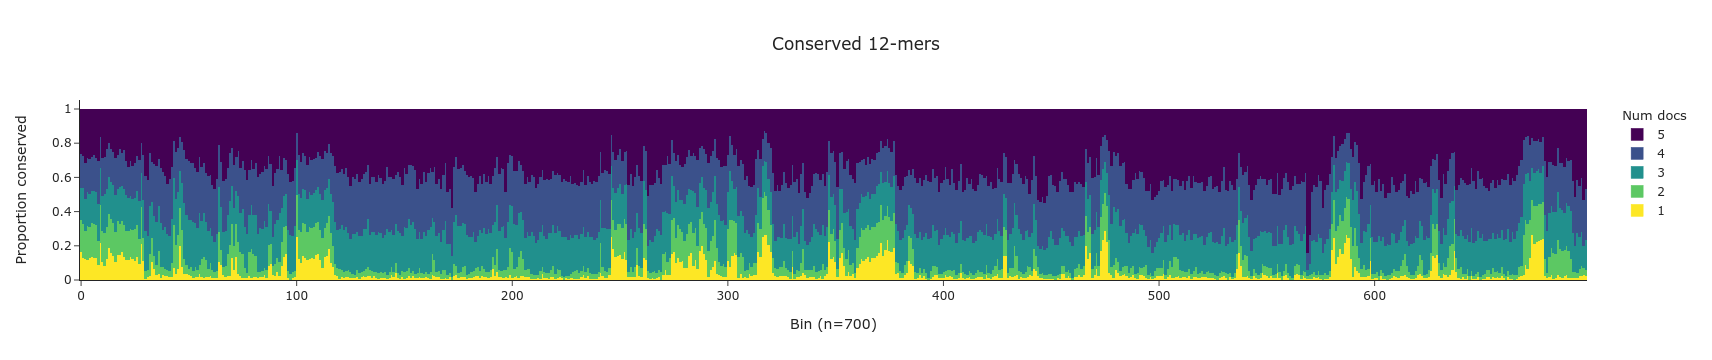

CPU times: user 4.32 s, sys: 636 ms, total: 4.96 s
Wall time: 30.3 s


In [94]:
%%time

# Plotly (no dash)

k = 12
data = update_data(k, n_bins)

fig = go.Figure()
for doc_idx in range(1, num_docs+2):
    doc_data = data[data['Num docs'] == str(doc_idx)]
    x = doc_data['bin']
    y = doc_data['value']
    color = dict(color=colors[doc_idx-1])
    name = str(doc_idx)
    
    fig.add_trace(go.Bar(x=x, y=y, name = name,
                         legendgroup="Num docs",
                         legendgrouptitle_text="Num docs",
                         marker=color,
                         marker_line=color))

fig.update_layout(barmode='stack', bargap=0.0, template="simple_white",
                 title={'text': "Conserved " + str(k) + '-mers', 
                        'x':0.5, 'xanchor': 'center', 
                        'yanchor': 'bottom'})
fig.update_xaxes(title_text="Bin (n=" + str(n_bins) +')') 
fig.update_yaxes(title_text="Proportion conserved")

fig.show()

In [ ]:
# k12
# no tabix: 13.6s 
# w  tabix: 30.3s

In [82]:
app = Dash(__name__)

app.layout = html.Div([
    html.H4('Interactive plot with custom data source'),
    dcc.Graph(id="graph"),
    html.P("Number of bars:"),
    dcc.Slider(id="slider", min=10, max=20, value=12, step=1),
])

@app.callback(
    Output("graph", "figure"),
    Input("slider", "value"))
def update_bar_chart(k):
    # run query
    data = update_data(k, n_bins)

    fig = go.Figure()
    for doc_idx in range(1, num_docs+2):
        doc_data = data[data['Num docs'] == str(doc_idx)]
        x, y = doc_data['bin'], doc_data['value']
        color = dict(color=colors[doc_idx-1])
        name = str(doc_idx)

        fig.add_trace(go.Bar(x=x, y=y, name = name,
                             legendgroup="Num docs",
                             legendgrouptitle_text="Num docs",
                             marker=color,
                             marker_line=color))

    fig.update_layout(barmode='stack', bargap=0.0, template="simple_white",
                      title={'text': "Conserved " + str(k) + '-mers', 
                            'x':0.5, 'xanchor': 'center', 
                            'yanchor': 'bottom'})
    fig.update_xaxes(title_text="Bin (n=" + str(n_bins) +')') 
    fig.update_yaxes(title_text="Proportion conserved")

    return fig

app.run_server(debug=True,  use_reloader=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [454]:
# sanity check: make all bins sum to 1
for x in range(n_bins-1):
    if sum(per_bin_doc_composition_df[per_bin_doc_composition_df['bin'] == x]['value']) <= 0.999:
        print(x, sum(per_bin_doc_composition_df[per_bin_doc_composition_df['bin'] == x]['value']))


# Plotting the MEMs converted with k

In [ ]:
# idea, some plotly r-shiny?
# have to first make a query -> file

# Ploting ordered MEMs coverage as stacks

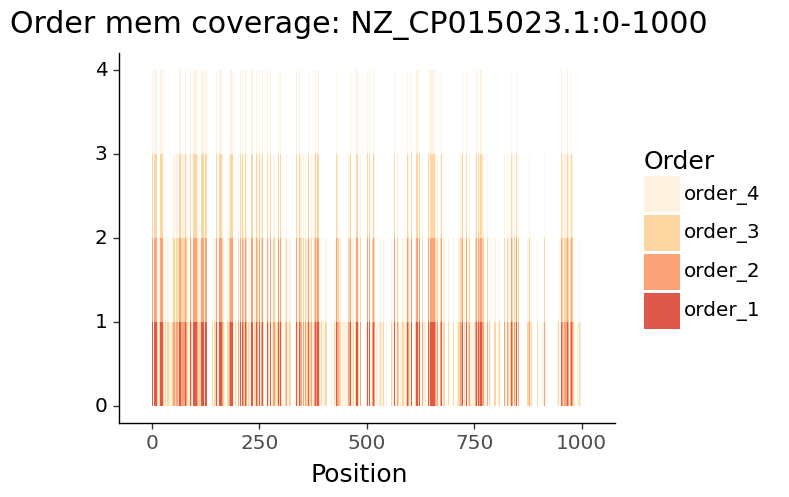

<ggplot: (8743346858415)>

In [71]:
# plot stacked bar plot
order_matrix = np.zeros((4, target[1] + target[2]))
for read in readList:
    chromosome, start, end, order = read
    order_matrix[order-1, start:end] += 1

order_names = ['order_1', 'order_2', 'order_3', 'order_4']    
data = pd.DataFrame(order_matrix.T, columns=order_names)
data['pos'] = data.index
colnames = list(data)
data = pd.melt(data, id_vars=colnames[-1], value_vars=colnames[:-1],
              var_name='Order', value_name='count')
data['Order'] = pd.Categorical(data['Order'], categories=order_names[::-1])

(
    ggplot(data, aes(x='pos', y='count', fill='Order')) +
    geom_bar(stat="identity", width=1, alpha=0.8) +
    ggtitle("Order mem coverage: " + target[0] + ':' + str(target[1]) + '-' + str(target[2])) +
    xlab("Position") +
    ylab("") +
    xlim(target[1] - buffer, target[2] + buffer) +
    scale_fill_manual(colors[::-1]) +
    theme_tufte_func(base_size=18, rotate=False)
)



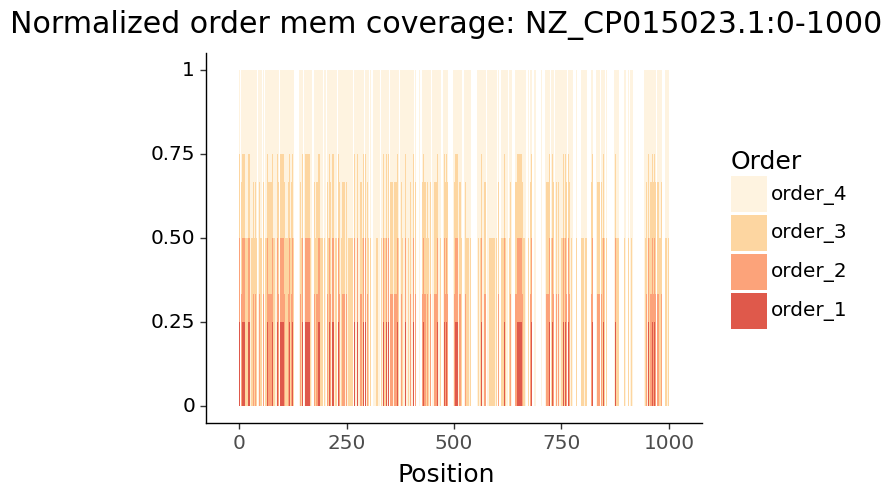

<ggplot: (8743345905378)>

In [70]:
# plot stacked bar plot (normalized)
order_matrix = np.zeros((4, target[1] + target[2]))
for read in readList:
    chromosome, start, end, order = read
    order_matrix[order-1, start:end] += 1
order_matrix =  order_matrix / order_matrix.sum(axis=0)

order_names = ['order_1', 'order_2', 'order_3', 'order_4']    
data = pd.DataFrame(order_matrix.T, columns=order_names)
data['pos'] = data.index
colnames = list(data)
data = pd.melt(data, id_vars=colnames[-1], value_vars=colnames[:-1],
              var_name='Order', value_name='count')
data['Order'] = pd.Categorical(data['Order'], categories=order_names[::-1])

(
    ggplot(data, aes(x='pos', y='count', fill='Order')) +
    geom_bar(stat="identity", width=1, alpha=0.8) +
    ggtitle("Normalized order mem coverage: " + target[0] + ':' + str(target[1]) + '-' + str(target[2])) +
    xlab("Position") +
    ylab("") +
    xlim(target[1] - buffer, target[2] + buffer) +
    scale_fill_manual(colors[::-1]) +
    theme_tufte_func(base_size=18, rotate=False)
)



# Interval overlap

In [ ]:
import argparse
import os
import pandas as pd
import numpy as np
from collections import Counter

def fileReader(path):
    ''' Read file from path line-by-line. '''
    with open(path, 'r') as inFile:
        for line in inFile:
            yield line.strip()

def parse_dap(dap_line):
    '''
    Parse document array profile.
        position, document_array
        [3,       65535, 13, 13, 13, 12]
    '''
    pos, *doc_array = map(int, dap_line.split(' '))
    doc_array.sort(reverse=True)
    return pos, doc_array

def find_mems(a):
    ''' Find MEMs from matching statistics. '''
    lm = np.r_[a[:-1] >= a[1:], True]
    return lm

def print_mem_doc_query(dap_stream, header, start_idx, end_idx):
    ''' Select MEMs from document array positions and print as bed-like format. '''
    row_idxs = list(range(start_idx, end_idx))
    row_list = []

    # skip to start_idx:
    curr_start_idx, *doc_array = parse_dap(next(dap_stream)) # first_row
    curr_start_idx = int(curr_start_idx)

    if curr_start_idx > start_idx:   # index stream must start <= desired index
        raise Exception('Start index error; ensure the order of the query \
                        matches the order found in the dap file.')

    # add first entry
    while curr_start_idx < start_idx:
        curr_start_idx, *doc_array = parse_dap(next(dap_stream)) # first_row
    row_list.append(doc_array[0])

    # parse rest of the entries
    for row in row_idxs[1:]:
        row_list.append(parse_dap(next(dap_stream))[1])
    num_docs = len(row_list[0])
    ar = np.array(row_list)

    # format print as bed
    for doc in range(1, num_docs):
        doc_array = ar[:,doc]
        mems = find_mems(doc_array)
        MEM_start = np.array(row_idxs)[mems]
        MEM_len = doc_array[mems]
        MEM_end = MEM_start + MEM_len
        print(*['\t'.join([header, *map(str, [start-start_idx, end-start_idx, doc])]) for start, end in zip(MEM_start, MEM_end) ], sep='\n')


################################################################################


def parse_arguments():
    """ Parses the command-line arguments, and returns them """
    parser = argparse.ArgumentParser(description="Takes in .fai and full document array profile and converts to bed-style MEM intervals to stdout.")
    parser.add_argument('--fai', dest='fai_path', help='path to fai file', required=True)
    parser.add_argument('--dap', dest='dap_path', help='path to full document profile', required=True)
    parser.add_argument('--query', dest="query", nargs='+', help='query regions', required=True)
    args = parser.parse_args()
    return args


def check_args(args):
    """ Check the command-line arguments and makes sure they are valid. """
    # Verify the files exist
    if not os.path.isfile(args.fai_path):
        print("Error: the fai file does not exist.")
        exit(1)
    if not os.path.isfile(args.dap_path):
        print("Error: the dap file does not exist.")
        exit(1)
    # Verify the files are the right type
    if not args.fai_path.endswith(".fai"):
        print("Error: the lengths file has the incorrect file extension.")
        exit(1)
    if not args.dap_path.endswith(".txt"):
        print("Error: the dap file has the incorrect file extension.")
        exit(1)


def main(args):
    # input paths
    fai_path = args.fai_path         # '/home/stephen/Documents/projects/langmead_lab/analysis/order_mems/bacteria_5/e_coli_pivot/input.fna.fai'
    dap_path = args.dap_path         # '/home/stephen/Documents/projects/langmead_lab/analysis/order_mems/bacteria_5/e_coli_pivot/full_dap.txt'
    query = args.query               # ['NZ_CP015023.1', 'NZ_CP015022.1']

    # fai parse
    fai_stream = fileReader(fai_path)
    interval_list = []
    for row in fai_stream:
        chrm, length, *_ = row.split()
        interval_list.append((chrm, int(length)))
    interval_df = pd.DataFrame(interval_list, columns=('chrm', 'length'))
    interval_df['end'] = interval_df['length'].cumsum()
    interval_df['start'] = interval_df['end'] - interval_df['length']

    # query pivot
    query_interval_df = interval_df[list(map(lambda _ : _ in query, interval_df['chrm']))]
    query_intervals = list(zip(query, zip(query_interval_df['start'], query_interval_df['end'])))

    # file path
    dap_stream  = fileReader(dap_path)
    for interval in query_intervals:
        header, start_stop = interval
        print_mem_doc_query(dap_stream, header, *start_stop)


if __name__ == "__main__":
    args = parse_arguments()
    check_args(args)
    main(args)


In [54]:
# fai parse (og)

fai_path = '/home/stephen/Documents/projects/langmead_lab/analysis/order_mems/bacteria_5/e_coli_pivot/input.fna.fai'

fai_stream = fileReader(fai_path)
interval_list = []
for row in fai_stream:
    chrm, length, *_ = row.split()
    interval_list.append((chrm, int(length)))
interval_df = pd.DataFrame(interval_list, columns=('chrm', 'length'))
interval_df['end'] = interval_df['length'].cumsum()
interval_df['start'] = interval_df['end'] - interval_df['length']
chrm_intervals_og = list(zip(interval_df['chrm'], interval_df['start'], interval_df['end']))


In [55]:
# fai parse (updated with walrus)

fai_path = '/home/stephen/Documents/projects/langmead_lab/analysis/order_mems/bacteria_5/e_coli_pivot/input.fna.fai'

fai_stream = fileReader(fai_path)
interval_list = []
csum = 0
for row in fai_stream:
    chrm, length, *_ = row.split()
    interval_list.append((chrm, csum, csum := csum+int(length)))
interval_list

assert interval_list == chrm_intervals_og

In [41]:
# fai parse

fai_path = '/home/stephen/Documents/projects/langmead_lab/analysis/order_mems/bacteria_5/e_coli_pivot/input.fna.fai'

fai_stream = fileReader(fai_path)
interval_list = []
csum = 0
for row in fai_stream:
    chrm, length, *_ = row.split()
    length = int(length)
    interval_list.append((chrm, csum, csum+length))
    csum += length
interval_list


#interval_df = pd.DataFrame(interval_list, columns=('chrm', 'length'))
#interval_df['end'] = interval_df['length'].cumsum()
#interval_df['start'] = interval_df['end'] - interval_df['length']
#chrm_intervals = list(zip(interval_df['chrm'], interval_df['start'], interval_df['end']))
#chrm_intervals


[('NZ_CP015023.1', 0, 5506801),
 ('NZ_CP015023.1_rev_comp', 5506801, 11013602),
 ('NZ_CP015022.1', 11013602, 11108772),
 ('NZ_CP015022.1_rev_comp', 11108772, 11203942),
 ('NC_000913.3', 11203942, 15845594),
 ('NC_000913.3_rev_comp', 15845594, 20487246),
 ('NC_016845.1', 20487246, 25821188),
 ('NC_016845.1_rev_comp', 25821188, 31155130),
 ('NC_016838.1', 31155130, 31277929),
 ('NC_016838.1_rev_comp', 31277929, 31400728),
 ('NC_016846.1', 31400728, 31511923),
 ('NC_016846.1_rev_comp', 31511923, 31623118),
 ('NC_016839.1', 31623118, 31729092),
 ('NC_016839.1_rev_comp', 31729092, 31835066),
 ('NC_016840.1', 31835066, 31838817),
 ('NC_016840.1_rev_comp', 31838817, 31842568),
 ('NC_016847.1', 31842568, 31845921),
 ('NC_016847.1_rev_comp', 31845921, 31849274),
 ('NC_016841.1', 31849274, 31850582),
 ('NC_016841.1_rev_comp', 31850582, 31851890),
 ('NZ_CP065890.1', 31851890, 36594450),
 ('NZ_CP065890.1_rev_comp', 36594450, 41337010),
 ('NZ_CP065891.1', 41337010, 41396053),
 ('NZ_CP065891.1_rev_c

In [48]:
chrm_intervals_2 == chrm_intervals

True

# MEM intervals to overlaps

In [124]:
def overlaps(a, b):
    """
    Return the amount of overlap, in bp
    between a and b.
    If >0, the number of bp of overlap
    If 0,  they are book-ended.
    If <0, the distance in bp between them
    """
    interval_start = max(start_prev, start_curr)
    interval_end = min(end_curr, end_prev)
    if interval_end > interval_start:
        #print(chrm_curr, interval_start, interval_end, order_mem_curr)
        return interval_start, interval_end
        #return None

In [127]:


num_docs = 4
l = [None for _ in range(num_docs)]

for record in readList2[:10]:
    chrm_curr, start_curr, end_curr, order_mem_curr, bl = record
    if l[order_mem_curr-1] is not None:
        chrm_prev, start_prev, end_prev = l[order_mem_curr-1]
        if chrm_curr == chrm_prev:
            intervals = overlaps((start_prev, end_prev), (start_curr, end_curr))
            if intervals is not None:
                print(chrm_curr, intervals[0], intervals[1], order_mem_curr)
    l[order_mem_curr-1] = [chrm_curr, start_curr, stop_curr]




NZ_CP015023.1 1 11 4
NZ_CP015023.1 2 11 1
NZ_CP015023.1 2 11 2
NZ_CP015023.1 2 11 3
NZ_CP015023.1 3 11 4
NZ_CP015023.1 3 11 1


In [120]:
readList2[:10]

num_docs = 4
l = [None for _ in range(num_docs)]
#print(l)

for record in readList2[:10]:
    chrm_curr, start_curr, end_curr, order_mem_curr, bl = record
    if l[order_mem_curr-1] is not None:
        chrm_prev, start_prev, end_prev = l[order_mem_curr-1]
    
        if chrm_curr == chrm_prev:
            interval_start = max(start_prev, start_curr)
            interval_end = min(end_curr, end_prev)
            if interval_end > interval_start:
                print(chrm_curr, interval_start, interval_end, order_mem_curr)

    l[order_mem_curr-1] = [chrm_curr, start_curr, stop_curr]


NZ_CP015023.1 1 11 4
NZ_CP015023.1 2 11 1
NZ_CP015023.1 2 11 2
NZ_CP015023.1 2 11 3
NZ_CP015023.1 3 11 4
NZ_CP015023.1 3 11 1


In [97]:
readList2[:10]

[['NZ_CP015023.1', 0, 10, 3, False],
 ['NZ_CP015023.1', 0, 10, 4, False],
 ['NZ_CP015023.1', 0, 11, 1, False],
 ['NZ_CP015023.1', 0, 11, 2, False],
 ['NZ_CP015023.1', 1, 11, 4, False],
 ['NZ_CP015023.1', 2, 16, 1, False],
 ['NZ_CP015023.1', 2, 16, 2, False],
 ['NZ_CP015023.1', 2, 16, 3, False],
 ['NZ_CP015023.1', 3, 15, 4, False],
 ['NZ_CP015023.1', 3, 16, 1, False]]

# Plot shadow dynamics

In [210]:
def fileReader(path):
    ''' Read file from path line-by-line. '''
    with open(path, 'r') as inFile:
        for line in inFile:
            yield line.strip()

In [279]:
def plot_kmer_Xs(data, title, ylab_):
    colnames = list(data)
    data = pd.melt(data, id_vars=colnames[0], value_vars=colnames[1:], var_name='Order')
    plot = (
        ggplot(data, aes(x='k', y='value', color='Order')) +
        geom_line(size=1, alpha=0.7) +
        ggtitle(title) +
        xlab("K") +
        ylab(ylab_) +
        scale_color_manual(colors) +
        theme_tufte_func(base_size=10, rotate=False)
    )
    return plot

In [212]:
def log2_transform_Xs(in_data):
    ''' log2(x+1) transform '''
    data = in_data.copy()
    for mem_order in list(data)[1:]:
        data[mem_order] = np.log2(data[mem_order] + 1)
    return data

In [213]:
def normalize_Xs_by_K(in_data, normalize_0_1=False):
    ''' Xs_drawn / k '''
    data = in_data.copy()
    for mem_order in list(data)[1:]:
        data[mem_order] /= all_k_df['k']
        if normalize_0_1:
            data[mem_order] /= np.max(data[mem_order])
    return data

In [254]:
stream_vary_k = fileReader('/home/stephen/Documents/projects/langmead_lab/analysis/order_mems/bacteria_5/e_coli_pivot/vary_k/summary_1.50.stats')

num_k_to_plot = 50
#colors = ['#386cb0', '#7fc97f', '#beaed4', '#fdc086', '#ffff99']     # diverging  
colors = ['#d7301f', '#fc8d59', '#fdcc8a', '#fef0d9']                 # oranges

colors = ['#ffffe5',
'#fff7bc',
'#fee391',
'#fec44f',
'#fe9929',
'#ec7014',
'#cc4c02',
'#8c2d04']
colors = colors[::-1]

# Parse and format data stream
k_row = []
all_k = []
for row in stream_vary_k:
    while row != '#':
        k_row.append(int(row))
        row = next(stream_vary_k)
    all_k.append(k_row)
    k_row = []
    
all_k = all_k[:num_k_to_plot]
all_k_df = pd.DataFrame(all_k, columns=['k','order_mem_1','order_mem_2','order_mem_3', 'order_mem_4'])
all_k_df

,k,order_mem_1,order_mem_2,order_mem_3,order_mem_4
0,1,0,0,0,0
1,2,0,0,0,0
2,3,0,0,0,0
3,4,0,0,0,0
4,5,0,0,0,0
5,6,0,0,0,0
6,7,0,0,0,0
7,8,0,0,13,168
8,9,39,238,1007,4072
9,10,1315,6428,25373,121887


In [256]:
Xs_drawn_path = '/home/stephen/Documents/projects/langmead_lab/omem/data/ani/summary.txt'
all_k_df = pd.read_csv(Xs_drawn_path, sep='\t', names=['k','order_mem_1','order_mem_2','order_mem_3', 'order_mem_4'], skiprows=1)
all_k_df

,k,order_mem_1,order_mem_2,order_mem_3,order_mem_4
0,6,0,0,0,0
1,7,0,0,0,0
2,8,0,0,13,168
3,9,39,238,1007,4072
4,10,1315,6428,25373,121887
5,11,33049,127595,419811,1228141
6,12,286578,756909,1899109,3436267
7,13,849509,1701345,3617867,4823022
8,14,1359915,2334435,4587051,5259461
9,15,1637076,2630725,4987455,5369182


In [288]:
all_k_df_increase

,k,order_mem_1,order_mem_2,order_mem_3,order_mem_4
0,1,0,0,0,0
1,2,0,0,13,168
2,3,39,238,994,3904
3,4,1276,6190,24366,117815
4,5,31734,121167,394438,1106254
5,6,253529,629314,1479298,2208126
6,7,562931,944436,1718758,1386755
7,8,510406,633090,969184,436439
8,9,277161,296290,400404,109721
9,10,127936,135847,150222,29824


In [262]:
colors = ['#993404',
'#d95f0e',
'#fe9929',
'#fed98e',
'#ffffd4']

In [290]:
all_k_df

,k,order_mem_1,order_mem_2,order_mem_3,order_mem_4
0,6,0,0,0,0
1,7,0,0,0,0
2,8,0,0,13,168
3,9,39,238,1007,4072
4,10,1315,6428,25373,121887
5,11,33049,127595,419811,1228141
6,12,286578,756909,1899109,3436267
7,13,849509,1701345,3617867,4823022
8,14,1359915,2334435,4587051,5259461
9,15,1637076,2630725,4987455,5369182


In [294]:
list(all_k_df.index)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [295]:
# Data for number Xs

# Data for increase of number Xs
#all_k_df_increase = pd.DataFrame(np.zeros((num_k_to_plot-1,5)), columns=['k','order_mem_1','order_mem_2','order_mem_3', 'order_mem_4'])
all_k_df_increase = pd.DataFrame(np.zeros((all_k_df.shape[0]-1,5)), columns=['k','order_mem_1','order_mem_2','order_mem_3', 'order_mem_4'])
for mem_order in list(all_k_df_increase)[1:]:
    all_k_df_increase[mem_order] = np.subtract(list(all_k_df[mem_order][1:]), list(all_k_df[mem_order][:-1]))
all_k_df_increase['k'] = all_k_df['k']

# Log2(x+1) transform data
all_k_df_log2 = log2_transform_Xs(all_k_df)
all_k_df_increase_log2 = log2_transform_Xs(all_k_df_increase)

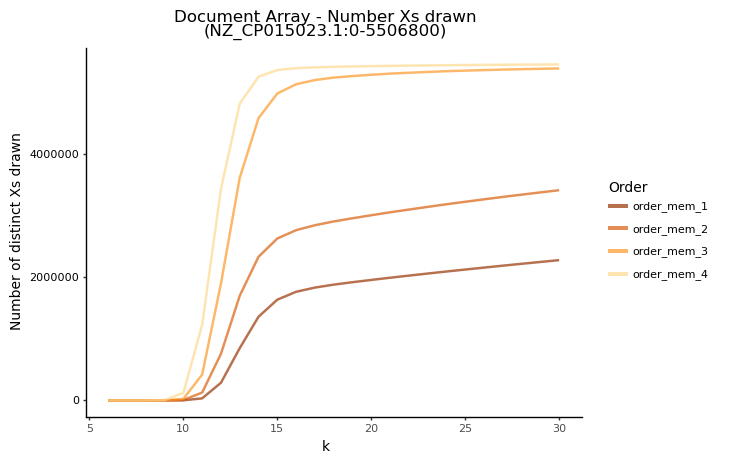

<ggplot: (8728345152853)>

In [264]:
num_X_plot = plot_kmer_Xs(all_k_df, 'Document Array - Number Xs drawn\n(NZ_CP015023.1:0-5506800)', "Number of distinct Xs drawn")
num_X_plot

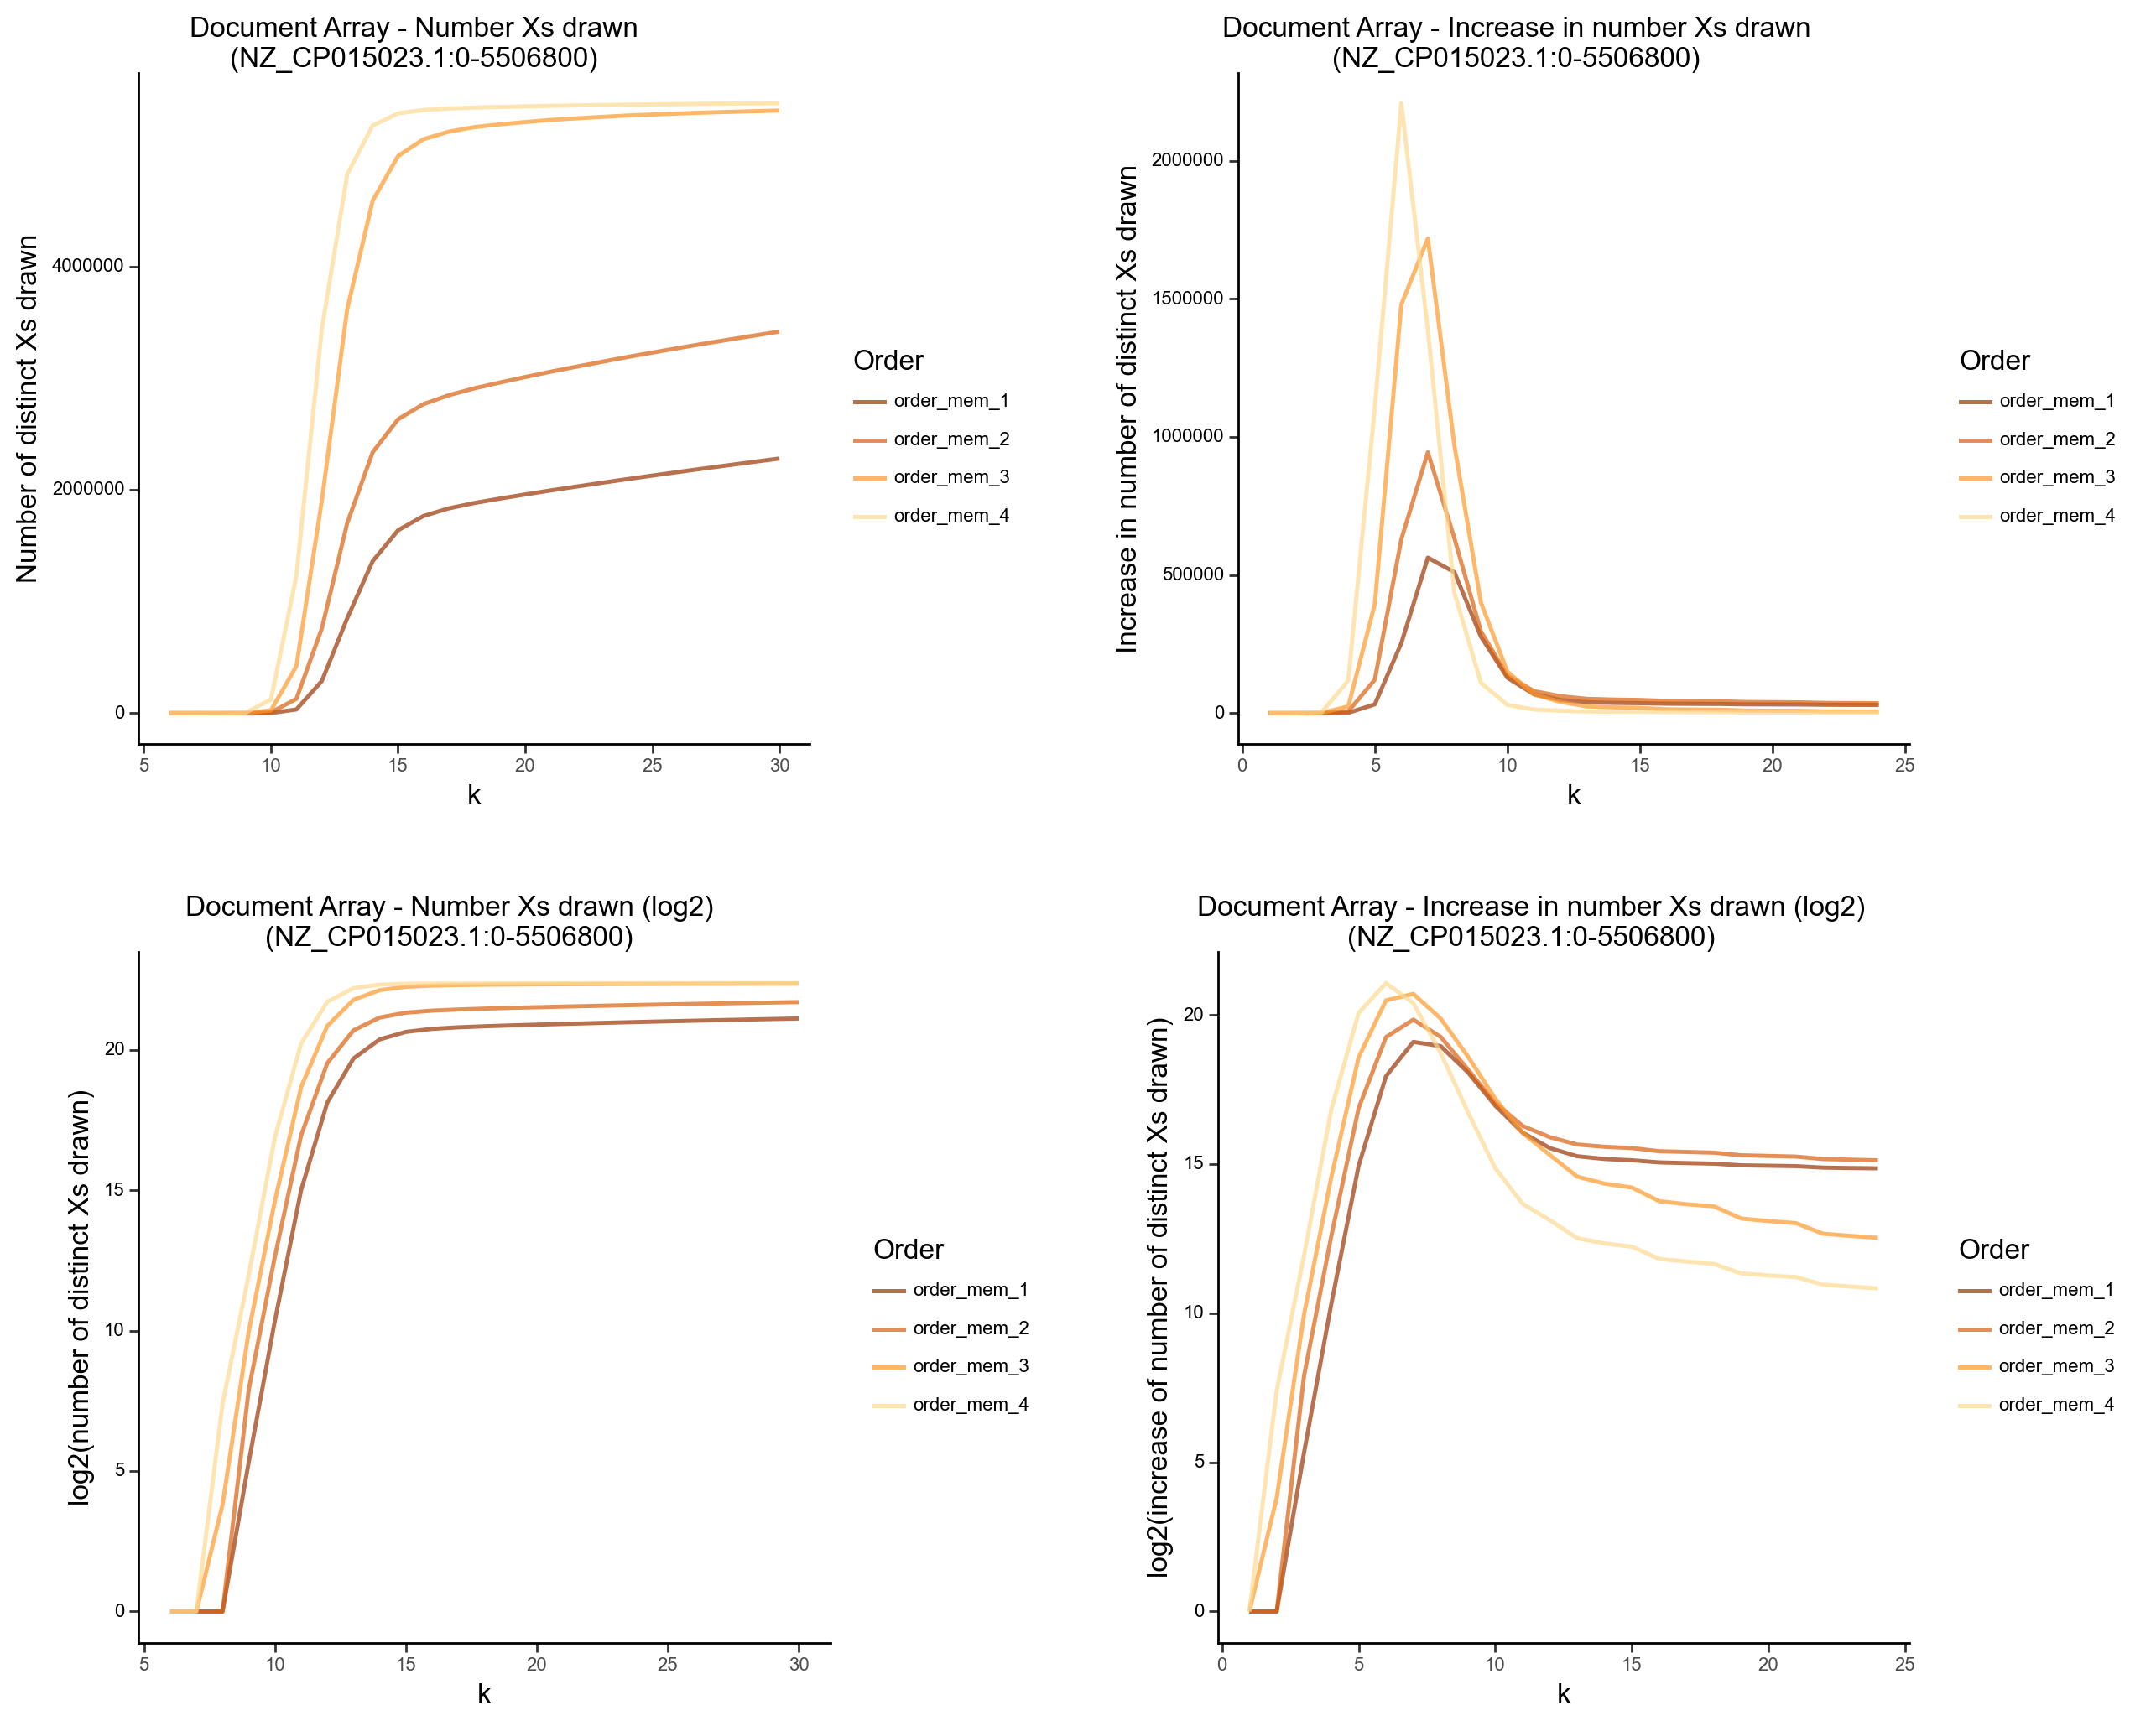

In [265]:
# Combine figures

# Number of Xs drawn
num_X_plot = plot_kmer_Xs(all_k_df, 'Document Array - Number Xs drawn\n(NZ_CP015023.1:0-5506800)', "Number of distinct Xs drawn")

# Increase of number of Xs drawn
increase_num_X_plot = plot_kmer_Xs(all_k_df_increase, 'Document Array - Increase in number Xs drawn\n(NZ_CP015023.1:0-5506800)', "Increase in number of distinct Xs drawn")

# Number of Xs drawn (log2)
num_X_plot_log2 = plot_kmer_Xs(all_k_df_log2, 'Document Array - Number Xs drawn (log2)\n(NZ_CP015023.1:0-5506800)', "log2(number of distinct Xs drawn)")

# Increase of number of Xs drawn (log2)
increase_num_X_plot_log2 = plot_kmer_Xs(all_k_df_increase_log2, 'Document Array - Increase in number Xs drawn (log2)\n(NZ_CP015023.1:0-5506800)', "log2(increase of number of distinct Xs drawn)")


# Combine figure
fig_lw = 4
pw1 = pw.load_ggplot(num_X_plot, figsize=(fig_lw,fig_lw))
pw2 = pw.load_ggplot(increase_num_X_plot, figsize=(fig_lw,fig_lw))
pw3 = pw.load_ggplot(num_X_plot_log2, figsize=(fig_lw,fig_lw))
pw4 = pw.load_ggplot(increase_num_X_plot_log2, figsize=(fig_lw,fig_lw))
pw_combine = ( (pw1|pw2) / (pw3|pw4) )
pw_combine

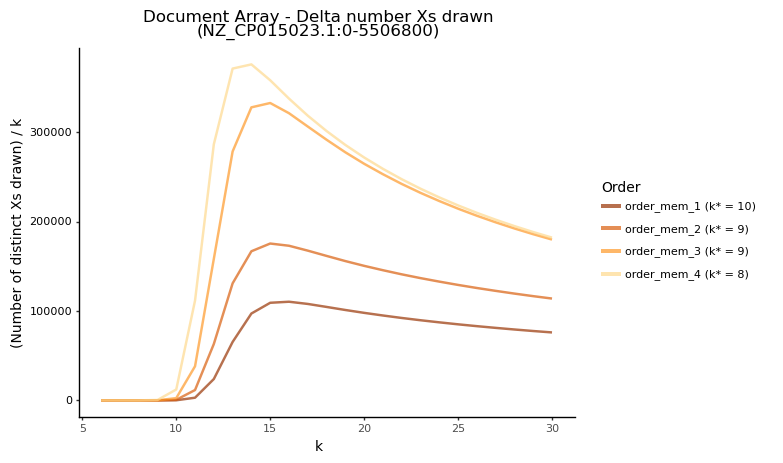

<ggplot: (8728361103059)>

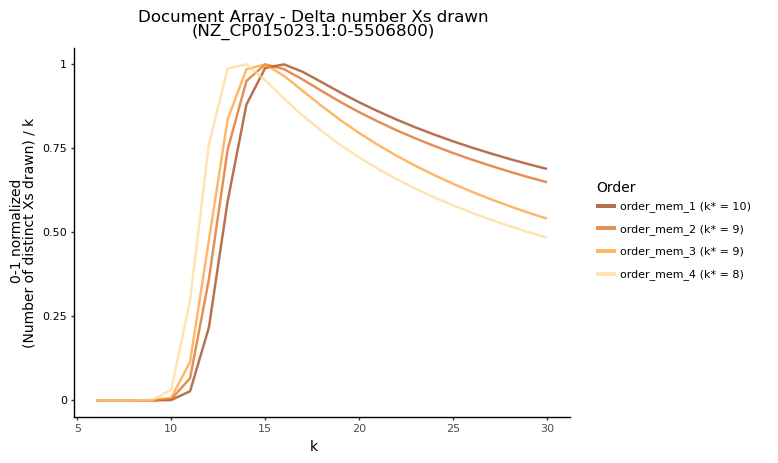

<ggplot: (8728360973695)>

In [271]:
# Delta K (0-1 normalize)
delta_all_k_df = normalize_Xs_by_K(all_k_df, normalize_0_1=True)
delta_all_k_df_norm_plot = plot_kmer_Xs(delta_all_k_df, 'Document Array - Delta number Xs drawn\n(NZ_CP015023.1:0-5506800)', "0-1 normalized\n(Number of distinct Xs drawn) / k ")

labels = []
for mem_order in list(delta_all_k_df)[1:]:
        labels.append(mem_order + ' (k* = ' + str(np.argmax(delta_all_k_df[mem_order])) + ')')


delta_all_k_df_norm_plot + scale_color_manual(colors, labels = labels)




In [272]:
# Argmax K for different order_mem-K schemes
for name, data in zip(('all_k_df_increase', 'all_k_df_increase_log2', 'delta_all_k_df'),
                (all_k_df_increase, all_k_df_increase_log2, delta_all_k_df)):
    print('\n'+name)
    for mem_order in list(data)[1:]:
        print(f"  {mem_order:12s} : {np.argmax(data[mem_order])}")



all_k_df_increase
  order_mem_1  : 6
  order_mem_2  : 6
  order_mem_3  : 6
  order_mem_4  : 5

all_k_df_increase_log2
  order_mem_1  : 6
  order_mem_2  : 6
  order_mem_3  : 6
  order_mem_4  : 5

delta_all_k_df
  order_mem_1  : 10
  order_mem_2  : 9
  order_mem_3  : 9
  order_mem_4  : 8


In [273]:
# Individual images

# Number of Xs drawn

# Increase of number of Xs drawn
increase_num_X_plot = plot_kmer_Xs(all_k_df_increase, 'Document Array - Increase in number Xs drawn\n(NZ_CP015023.1:0-5506800)', "Increase in number of distinct Xs drawn")

# Number of Xs drawn (log2)
num_X_plot_log2 = plot_kmer_Xs(all_k_df_log2, 'Document Array - Number Xs drawn (log2)\n(NZ_CP015023.1:0-5506800)', "log2(number of distinct Xs drawn)")

# Increase of number of Xs drawn (log2)


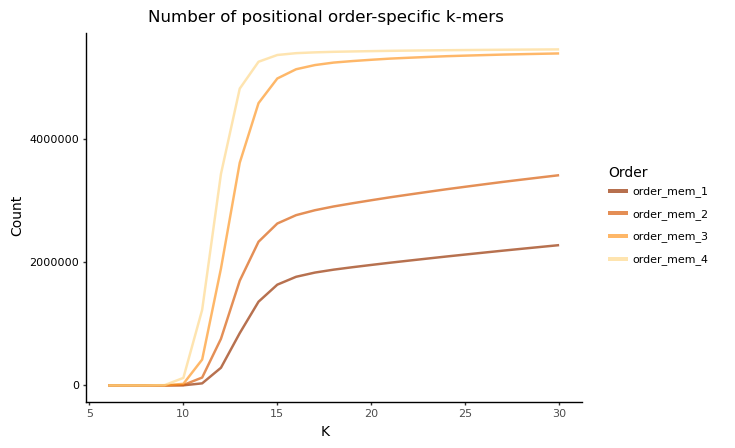

<ggplot: (8728360669377)>

In [281]:
# Document Array - Number Xs drawn\n(NZ_CP015023.1:0-5506800) 
num_X_plot = plot_kmer_Xs(all_k_df, 'Number of positional order-specific k-mers', "Count")
num_X_plot

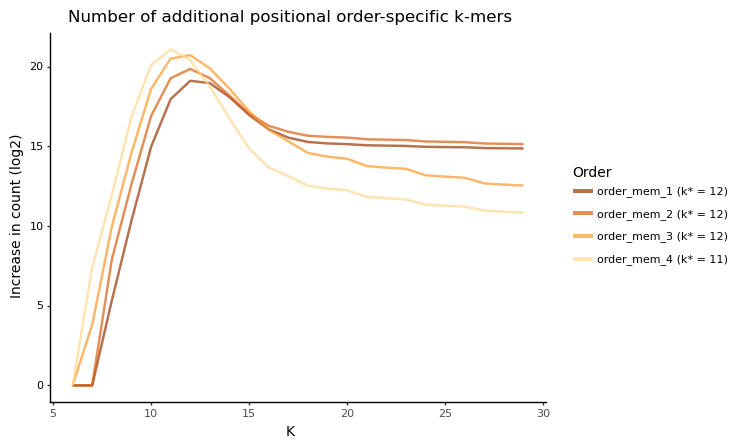

<ggplot: (8728343174099)>

In [305]:
# Document Array - Increase in number Xs drawn (log2)\n(NZ_CP015023.1:0-5506800)

increase_num_X_plot_log2 = plot_kmer_Xs(all_k_df_increase_log2, 'Number of additional positional order-specific k-mers', "Increase in count (log2)")

labels = []
for mem_order in list(all_k_df_increase_log2)[1:]:
        #labels.append(mem_order + ' (k* = ' + str(np.argmax(all_k_df_increase_log2[mem_order])) + ')')
        labels.append(mem_order + ' (k* = ' + str(list(all_k_df_increase_log2['k'])[np.argmax(all_k_df_increase_log2[mem_order])]) + ')')

increase_num_X_plot_log2 + scale_color_manual(colors, labels = labels)


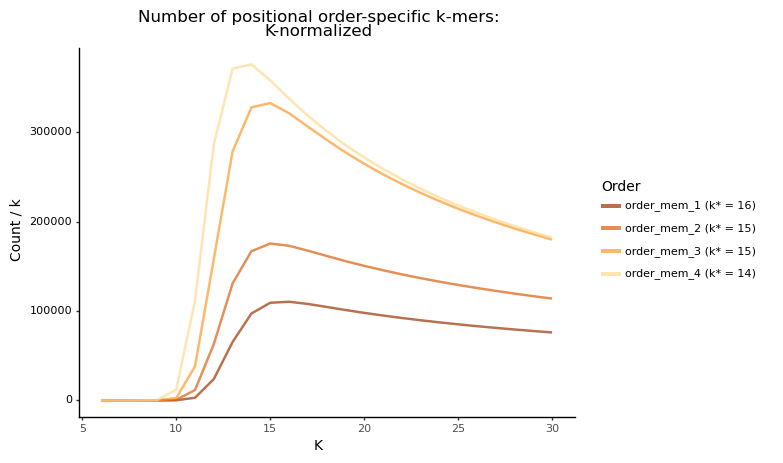

<ggplot: (8728343042985)>

In [311]:
# Delta K
# Document Array - Delta number Xs drawn\n(NZ_CP015023.1:0-5506800)

delta_all_k_df = normalize_Xs_by_K(all_k_df)
delta_all_k_df_plot = plot_kmer_Xs(delta_all_k_df, 'Number of positional order-specific k-mers:\nK-normalized', "Count / k")

labels = []
for mem_order in list(delta_all_k_df)[1:]:
        labels.append(mem_order + ' (k* = ' + str(list(all_k_df_increase_log2['k'])[np.argmax(delta_all_k_df[mem_order])]) + ')')

delta_all_k_df_plot + scale_color_manual(colors, labels = labels)

In [ ]:
num_X_plot_log2

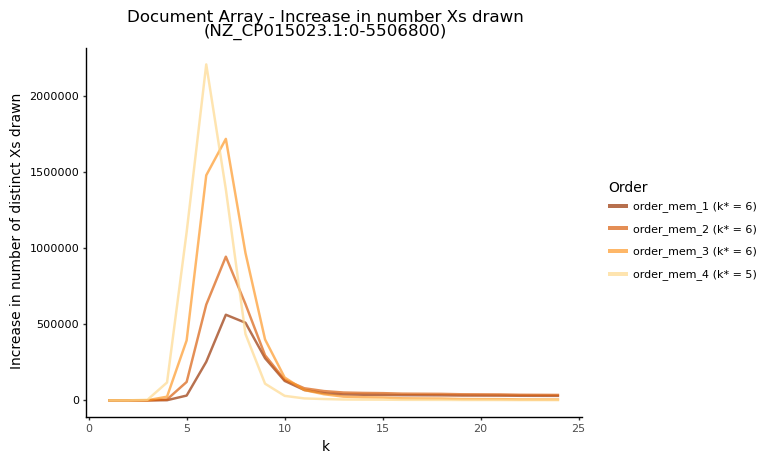

<ggplot: (8728343181078)>

In [306]:

labels = []
for mem_order in list(all_k_df_increase)[1:]:
        labels.append(mem_order + ' (k* = ' + str(np.argmax(all_k_df_increase[mem_order])) + ')')

increase_num_X_plot + scale_color_manual(colors, labels = labels)


array([11, 10, 11, 11, 11, 12, 11, 11, 11, 11])

# Validate full_dap.txt


In [181]:
#path = "/home/stephen/Documents/projects/langmead_lab/omem/data/example_dap/compare_dap/og_dap.txt"     # orignal contains valid LCPs
#path = "/home/stephen/Documents/projects/langmead_lab/omem/data/example_dap/compare_dap/dap_sort.txt"    # new contains jumps
#path = "/home/stephen/Documents/projects/langmead_lab/omem/src/full_dap.txt"  # new main branch code
path = paths[1]

DAP_flat = np.fromfile(path, dtype=int, sep=' ')
DAP = np.reshape(DAP_flat, (-1, 6))    # reshape to: | index + 5 docs |
DAP = DAP[:,2:]                        # remove index col and self-map LCP col

# check here that each consecutive LCP is no more than +1 larger
all_omems = [DAP[:,order][::-1] for order in range(4)]
for order, omem_array in enumerate(all_omems):
    step_size = omem_array[1:] - omem_array[:-1]
    assert np.all(step_size <= 1)
    #assert np.all(omem_array[1:] - omem_array[:-1] <= 1)
    #print(order, np.argmax(step_size[::-1]), max(step_size))

AssertionError: 

In [180]:
paths = ['/home/stephen/Documents/projects/langmead_lab/omem/data/bacteria_pangeome_fasta/daps/dap_cp/sorted/shigella_dap.txt',
'/home/stephen/Documents/projects/langmead_lab/omem/data/bacteria_pangeome_fasta/daps/dap_cp/sorted/salmonella_dap.txt',
'/home/stephen/Documents/projects/langmead_lab/omem/data/bacteria_pangeome_fasta/daps/dap_cp/sorted/klebsiella_dap.txt',
'/home/stephen/Documents/projects/langmead_lab/omem/data/bacteria_pangeome_fasta/daps/dap_cp/sorted/e_coli_k12_dap.txt',
'/home/stephen/Documents/projects/langmead_lab/omem/data/bacteria_pangeome_fasta/daps/dap_cp/sorted/e_coli_dap.txt']

paths = ['/home/stephen/Documents/projects/langmead_lab/omem/data/bacteria_pangeome_fasta/daps/dap_cp/raw/shigella.fna.extract_dap.txt',
'/home/stephen/Documents/projects/langmead_lab/omem/data/bacteria_pangeome_fasta/daps/dap_cp/raw/salmonella.fna.extract_dap.txt',
'/home/stephen/Documents/projects/langmead_lab/omem/data/bacteria_pangeome_fasta/daps/dap_cp/raw/klebsiella.fna.extract_dap.txt',
'/home/stephen/Documents/projects/langmead_lab/omem/data/bacteria_pangeome_fasta/daps/dap_cp/raw/e_coli_k12.fna.extract_dap.txt',
'/home/stephen/Documents/projects/langmead_lab/omem/data/bacteria_pangeome_fasta/daps/dap_cp/raw/e_coli.fna.extract_dap.txt']


# X summary to k*

In [26]:
path = "/home/stephen/Documents/projects/langmead_lab/omem/workflow/results/summary.txt"
num_docs = 4

Xs_flat = np.fromfile(path, dtype=int, sep='\t')
X_mat = np.reshape(Xs_flat, (-1, num_docs+1))
K_s = X_mat[:,0]

for doc_idx in range(1, num_docs+1):
    sub_mat = X_mat[:,doc_idx]
    print('order-'+str(doc_idx)+' k*:', K_s[np.argmax(sub_mat[1:] - sub_mat[:-1])])


order-1 k*: 12
order-2 k*: 12
order-3 k*: 12
order-4 k*: 11


In [42]:
def find_k_star(path, num_docs):
    ''' Find k* for each order MEM. '''
    x_array = np.fromfile(path, dtype=int, sep='\t')
    x_mat = np.reshape(x_array, (-1, num_docs+1))
    K_s = x_mat[:,0]
    for doc_idx in range(1, num_docs+1):
        sub_mat = x_mat[:,doc_idx]
        print('order-'+str(doc_idx)+' k*:', K_s[np.argmax(sub_mat[1:] - sub_mat[:-1]) + 1])   # NOTE: +1 for upper

find_k_star(path, num_docs)

order-1 k*: 13
order-2 k*: 13
order-3 k*: 13
order-4 k*: 12


In [37]:
def find_k_delta(path, num_docs):
    ''' Find k* for each order MEM. '''
    x_array = np.fromfile(path, dtype=int, sep='\t')
    x_mat = np.reshape(x_array, (-1, num_docs+1))
    K_s = x_mat[:,0]
    for doc_idx in range(1, num_docs+1):
        sub_mat_norm = x_mat[:,doc_idx] / K_s
        print('order-'+str(doc_idx)+' k*:', K_s[np.argmax(sub_mat_norm) + 1])   # NOTE: +1 for upper

find_k_delta(path, num_docs)

order-1 k*: 17
order-2 k*: 16
order-3 k*: 16
order-4 k*: 15


# Plot some length distributions

In [1]:
path = "/home/stephen/Documents/projects/langmead_lab/omem/data/bacteria_pangeome_fasta/omem_olaps/omem_olaps_no_head.bed"

omem_olaps_flat = np.fromfile(path, dtype=int, sep='\t')
X_mat = np.reshape(omem_olaps_flat, (-1, 3))
X_mat


array([[      1,      10,       3],
       [      1,      10,       4],
       [      1,      11,       1],
       ...,
       [5506789, 5506799,       3],
       [5506790, 5506800,       3],
       [5506791, 5506800,       4]])

In [2]:
# length of overlap-MEMs for varying order
for doc_idx in range(1, 5):
    sub_mat = X_mat[X_mat[:,2] == doc_idx]


In [3]:
# order-1 overlap MEM

sub_mat_1 = X_mat[X_mat[:,2] == 1]


emerge_array = sub_mat_1[:,1] - sub_mat_1[:,0]               # emerge: length of MEM overlap
emerge_array = emerge_array[1:]

sub_mat_1_starts = sub_mat_1[:,0]
bump_array = sub_mat_1_starts[1:] - sub_mat_1_starts[:-1]    # bump: dist between consec starts

sub_mat_1_ends = sub_mat_1[:,1]
joint_array = sub_mat_1_ends[1:] - sub_mat_1_starts[:-1]     # joint: dist between consec starts + end

#assert
#joint_sum_same = emerge_array[1:] + bump_array == joint_array
joint_sum_same = emerge_array + bump_array == joint_array
assert joint_sum_same.all()

In [4]:
data = pd.DataFrame( zip(emerge_array, bump_array, joint_array), columns=['Emerge','Bump','Joint'] )

In [5]:
data

,Emerge,Bump,Joint
0,10,1,11
1,11,3,14
2,10,2,12
3,9,2,11
4,9,1,10
...,...,...,...
1007327,12,2,14
1007328,10,6,16
1007329,10,1,11
1007330,11,1,12


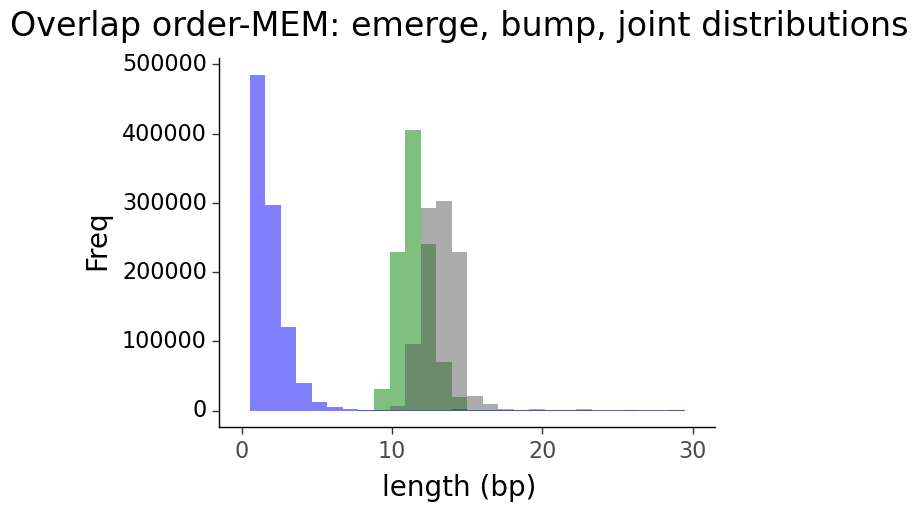

<ggplot: (8728366548399)>

In [11]:
# plot the three distributions

bin_num = 100
x_lim_val = 30 #int(bin_num * 1.25)

(
    ggplot(data) +
    geom_histogram(aes(x='Emerge'), bins=30, fill='green', alpha=0.5) +
    geom_histogram(aes(x='Bump'), bins=30, fill='blue', alpha=0.5) +
    geom_histogram(aes(x='Joint'), bins=30, alpha=0.5) +
    ggtitle("Overlap order-MEM: emerge, bump, joint distributions") +
    xlab("length (bp)") +
    ylab("Freq") +
    xlim(0, x_lim_val) +
    theme_tufte_func(base_size=20, rotate=False)
)

In [12]:
from random import randint

In [13]:
num_samples = data.shape[0]

joint_rand = []
for _ in range(num_samples):
    emerge_idx, bump_idx = randint(0,num_samples-1), randint(0,num_samples-1)
    emerge_val = data['Emerge'][emerge_idx]
    bump_val = data['Bump'][bump_idx]
    joint_rand.append(emerge_val + bump_val)
    
data['Joint_sampled'] = joint_rand
data

,Emerge,Bump,Joint,Joint_sampled
0,10,1,11,13
1,11,3,14,12
2,10,2,12,13
3,9,2,11,14
4,9,1,10,12
...,...,...,...,...
1007327,12,2,14,13
1007328,10,6,16,12
1007329,10,1,11,13
1007330,11,1,12,14


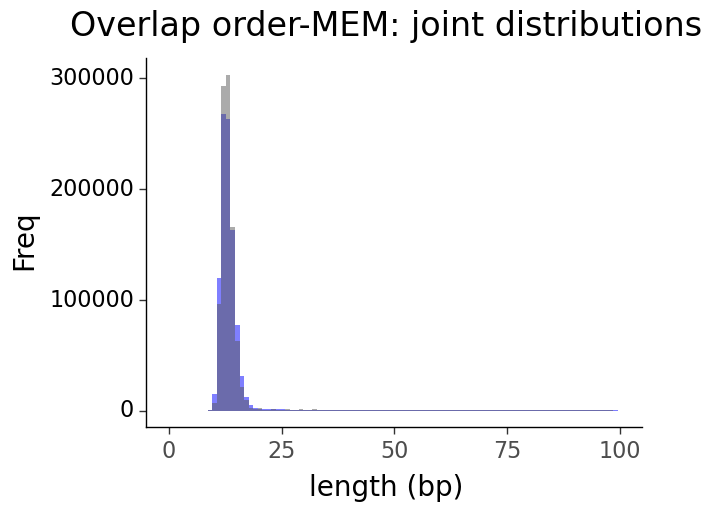

<ggplot: (8728364353922)>

In [14]:
# Joint random and empirical
(
    ggplot(data) +
    geom_histogram(aes(x='Joint_sampled'), bins=100, fill='blue', alpha=0.5) +
    geom_histogram(aes(x='Joint'), bins=100, alpha=0.5) +
    ggtitle("Overlap order-MEM: joint distributions") +
    xlab("length (bp)") +
    ylab("Freq") +
    xlim(0, 100) +
    theme_tufte_func(base_size=20, rotate=False)
)

In [15]:
from scipy.stats import ttest_ind

joint_distr = list(data['Joint'])
joint_rand_distr = list(data['Joint_sampled'])
ttest_ind(joint_distr, joint_rand_distr)

# conclusion: same distribution

Ttest_indResult(statistic=1.366360522138103, pvalue=0.17182598586834413)

In [16]:
from scipy import stats

# spearman correlation between emerge and bump size
stats.spearmanr(list(data['Emerge']), list(data['Bump']))

# conclusion: slight negative correlation
#    larger emerge length, smaller bump length


SpearmanrResult(correlation=-0.12105782299181472, pvalue=0.0)

In [ ]:
data['Joint_sorted'] = sorted(list(data['Joint']))
data['Joint_sampled_sorted'] = sorted(list(data['Joint_sampled']))
data

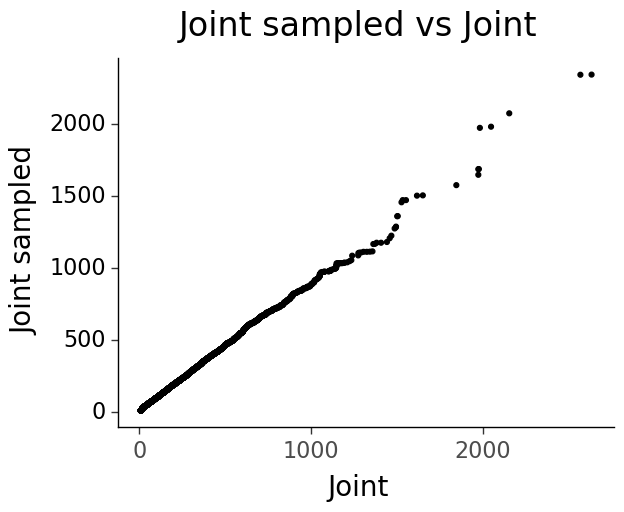

<ggplot: (8728364211857)>

In [25]:
# plot relationship

# Joint random and empirical
(
    ggplot(data, aes(x='Joint_sorted', y='Joint_sampled_sorted')) +
    geom_point() +
    ggtitle("Joint sampled vs Joint") +
    xlab("Joint") +
    ylab("Joint sampled") +
    theme_tufte_func(base_size=20, rotate=False)
)

In [342]:
# check if sampled and joint sample same distribution

from scipy.stats import ranksums


ranksums(joint_distr, joint_rand_distr)
# H0: same distribution
# Ha: one of the distributions is greater than the other
# 
# RanksumsResult(statistic=-11.317145661683538, pvalue=1.0792901673856867e-29)
# p-value < 0.05 : reject the null, different distributions
#


RanksumsResult(statistic=-11.317145661683538, pvalue=1.0792901673856867e-29)

In [337]:
np.mean(joint_distr)


17.159027013933837

In [338]:
np.mean(joint_rand_distr)

17.11979466551246

Ttest_indResult(statistic=0.8422670441191799, pvalue=0.39963859354026954)

# ANI tests
E. coli pivot in 5-bacteria pangenome


In [9]:
Xs_drawn_path = '/home/stephen/Documents/projects/langmead_lab/omem/data/ani/E_coli_Xs_drawn.tsv'

data = pd.read_csv(Xs_drawn_path, sep='\t', names=['k','Order_1','Order_2','Order_3','Order_4'], skiprows=1)
k_star = dict(data.iloc[13])
k_plus = dict(data.iloc[14])
data = data.drop(13)
data = data.drop(14)
data

,k,Order_1,Order_2,Order_3,Order_4
0,8,0,0,13,168
1,9,39,238,1007,4072
2,10,1315,6428,25373,121887
3,11,33049,127595,419811,1228141
4,12,286578,756909,1899109,3436267
5,13,849509,1701345,3617867,4823022
6,14,1359915,2334435,4587051,5259461
7,15,1637076,2630725,4987455,5369182
8,16,1765012,2766572,5137677,5399006
9,17,1833382,2846487,5205537,5412064


In [10]:
genome_len = 5506801
Ks = data['k']


In [11]:
Ks_array = np.array(Ks, dtype='int')
data['D_Order_1'] = -1 / Ks_array * np.log((genome_len - data['Order_1']) / genome_len)
data['D_Order_2'] = -1 / Ks_array * np.log((genome_len - data['Order_2']) / genome_len)
data['D_Order_3'] = -1 / Ks_array * np.log((genome_len - data['Order_3']) / genome_len)
data['D_Order_4'] = -1 / Ks_array * np.log((genome_len - data['Order_4']) / genome_len)
data

,k,Order_1,Order_2,Order_3,Order_4,D_Order_1,D_Order_2,D_Order_3,D_Order_4
0,8,0,0,13,168,-0.000000e+00,-0.000000,2.950900e-07,0.000004
1,9,39,238,1007,4072,7.869085e-07,0.000005,2.032017e-05,0.000082
2,10,1315,6428,25373,121887,2.388241e-05,0.000117,4.618223e-04,0.002238
3,11,33049,127595,419811,1228141,5.472336e-04,0.002131,7.208870e-03,0.022940
4,12,286578,756909,1899109,3436267,4.453646e-03,0.012322,3.524297e-02,0.081515
5,13,849509,1701345,3617867,4823022,1.288844e-02,0.028427,8.230548e-02,0.160470
6,14,1359915,2334435,4587051,5259461,2.025901e-02,0.039393,1.278312e-01,0.221641
7,15,1637076,2630725,4987455,5369182,2.352003e-02,0.043304,1.574113e-01,0.245950
8,16,1765012,2766572,5137677,5399006,2.415125e-02,0.043621,1.689129e-01,0.245844
9,17,1833382,2846487,5205537,5412064,2.381536e-02,0.042796,1.709266e-01,0.238979


## Plotting Mash distance vs Mash formula with Xs

In [12]:
distance_path = '/home/stephen/Documents/projects/langmead_lab/omem/data/ani/E_coli_ANI.tsv'
data = pd.read_csv(distance_path, sep='\t')
data

# pivot :  ecoli
# Doc_1 :  ecoli_k12
# Doc_2 :  klebsiella
# Doc_3 :  salmonella
# Doc_4 :  shigella

,K,FastANI_doc1,FastANI_doc2,FastANI_doc3,FastANI_doc4,FastANI_avg,Mash_D_doc1,Mash_D_doc2,Mash_D_doc3,Mash_D_doc4,Mash_D_avg,Mash_D_concat_docs,Mash_D_with_Xs_order_1,Mash_D_with_Xs_order_2,Mash_D_with_Xs_order_3,Mash_D_with_Xs_order_4
0,8,97.0654,95.9676,83.7206,82.7760,89.8824,0.000063,0.000000,0.000063,0.000063,0.000047,0.000000,0.000000e+00,0.000000,2.950000e-07,0.000004
1,9,97.0029,95.9484,81.4503,80.1461,88.6369,0.000391,0.000391,0.000391,0.000447,0.000405,0.000279,7.870000e-07,0.000005,2.030000e-05,0.000082
2,10,97.1598,96.4059,81.8932,80.6579,89.0292,0.002978,0.003528,0.003918,0.002923,0.003336,0.002436,2.390000e-05,0.000117,4.620000e-04,0.002238
3,11,97.3644,96.5665,81.5300,80.7350,89.0490,0.007977,0.018500,0.018267,0.010519,0.013816,0.010708,5.470000e-04,0.002131,7.210000e-03,0.022940
4,12,97.3810,96.5486,81.8532,81.0592,89.2105,0.017682,0.051656,0.055264,0.021782,0.036596,0.033789,4.450000e-03,0.012322,3.520000e-02,0.081515
5,13,97.4879,96.7335,81.9526,80.9761,89.2875,0.022451,0.094677,0.093914,0.025577,0.059155,0.051843,1.290000e-02,0.028427,8.230000e-02,0.160470
6,14,97.5390,96.7355,81.3533,80.2640,88.9730,0.026038,0.152326,0.133964,0.032250,0.086145,0.064097,2.030000e-02,0.039393,1.280000e-01,0.221641
7,15,97.5794,96.8657,81.9337,80.6192,89.2495,0.025215,0.194001,0.172620,0.032727,0.106000,0.063300,2.350000e-02,0.043304,1.570000e-01,0.245950
8,16,97.7171,97.0465,82.1999,80.9569,89.4801,0.025342,0.199429,0.193866,0.030583,0.112000,0.071900,2.420000e-02,0.043621,1.690000e-01,0.245844
9,17,97.6333,96.9162,81.8933,80.2629,89.1764,0.025712,0.196593,0.196593,0.030491,0.112000,0.058700,2.380000e-02,0.042796,1.710000e-01,0.238979


In [13]:
data_to_melt = data[['K', 'Mash_D_avg', 'Mash_D_concat_docs', 'Mash_D_with_Xs_order_1']]
data_melted = data_to_melt.melt(id_vars=['K'], var_name='Distance measure:')
rename_dict = {
    'Mash_D_avg'             : 'Mash: k-mer counts, avg. docs',
    'Mash_D_concat_docs'     : 'Mash: k-mer counts, concat. docs',
    'Mash_D_with_Xs_order_1' : 'OMEM: non-unique k-mer pos.'}
data_melted['Distance measure'] = list(map(rename_dict.get, data_melted['Distance measure:']))
data_melted

,K,Distance measure:,value,Distance measure
0,8,Mash_D_avg,4.690000e-05,"Mash: k-mer counts, avg. docs"
1,9,Mash_D_avg,4.049885e-04,"Mash: k-mer counts, avg. docs"
2,10,Mash_D_avg,3.336498e-03,"Mash: k-mer counts, avg. docs"
3,11,Mash_D_avg,1.381576e-02,"Mash: k-mer counts, avg. docs"
4,12,Mash_D_avg,3.659590e-02,"Mash: k-mer counts, avg. docs"
5,13,Mash_D_avg,5.915490e-02,"Mash: k-mer counts, avg. docs"
6,14,Mash_D_avg,8.614460e-02,"Mash: k-mer counts, avg. docs"
7,15,Mash_D_avg,1.060000e-01,"Mash: k-mer counts, avg. docs"
8,16,Mash_D_avg,1.120000e-01,"Mash: k-mer counts, avg. docs"
9,17,Mash_D_avg,1.120000e-01,"Mash: k-mer counts, avg. docs"


In [38]:
a = data_melted[data_melted['Distance measure:'] == 'Mash_D_avg']['value'] / max(data_melted[data_melted['Distance measure:'] == 'Mash_D_avg']['value'])
b = data_melted[data_melted['Distance measure:'] == 'Mash_D_concat_docs']['value'] / max(data_melted[data_melted['Distance measure:'] == 'Mash_D_concat_docs']['value'])
c = data_melted[data_melted['Distance measure:'] == 'Mash_D_with_Xs_order_1']['value'] / max(data_melted[data_melted['Distance measure:'] == 'Mash_D_with_Xs_order_1']['value'])

In [36]:
data_melted['norm'] = list(a) + list(b) + list(c)

In [14]:

color_dict = {
    'Mash: k-mer set, avg. docs'     : '#66c2a5',
    'Mash: k-mer set, concat. docs'  : '#fc8d62',
    'OMEM: non-unique k-mer pos.'       : '#8da0cb'}

colors = list(color_dict.values())
lab = list(color_dict.keys())

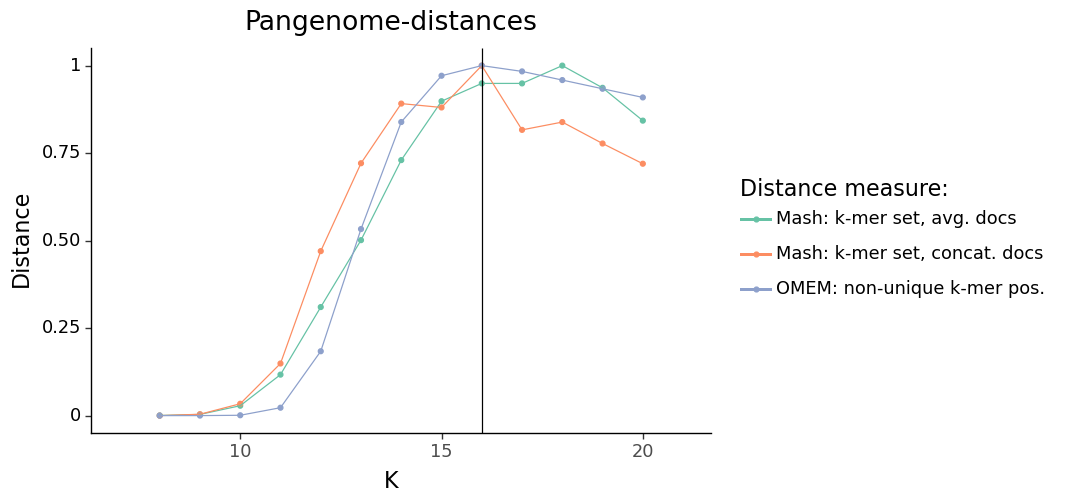

<ggplot: (8774438804932)>

In [37]:
# plot distances
(
    ggplot(data_melted, aes(x='K', y='norm', color='Distance measure:')) +
    geom_point() +
    geom_line() +
    scale_color_manual(colors, labels=lab) +
    geom_vline(xintercept=16) +
    #geom_vline(xintercept=13) +
    ggtitle("Pangenome-distances") +
    xlab("K") +
    ylab("Distance") +
    xlim(7,21) +
    theme_tufte_func(base_size=16,
                     rotate=False,
                    figure_size=(8,5)) #+
    #theme(legend_position='bottom',
          #legend_direction='vertical')
)


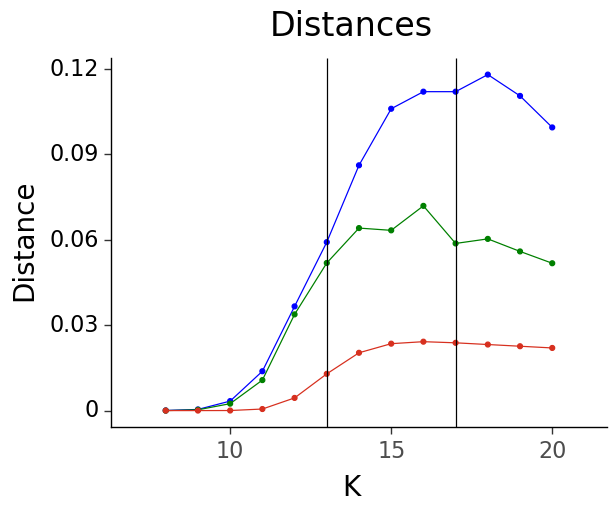

<ggplot: (8728360419648)>

In [145]:
# plot distances

colors = ['#d7301f', '#fc8d59', '#fdcc8a', '#fef0d9']

(
    ggplot(data) +
    geom_point(aes(x='K', y='Mash_D_avg'), color='blue') +
    geom_line(aes(x='K', y='Mash_D_avg'), color='blue') +
    
    geom_point(aes(x='K', y='Mash_D_concat_docs'), color='green') +
    geom_line(aes(x='K', y='Mash_D_concat_docs'), color='green') +
    
    geom_point(aes(x='K', y='Mash_D_with_Xs_order_1'), color=colors[0]) +
    geom_line(aes(x='K', y='Mash_D_with_Xs_order_1'), color=colors[0]) +
    
    #geom_point(aes(x='K', y='Mash_D_with_Xs_order_2'), color=colors[1]) +
    #geom_line(aes(x='K', y='Mash_D_with_Xs_order_2'), color=colors[1]) +
    #geom_point(aes(x='K', y='Mash_D_with_Xs_order_3'), color=colors[2]) +
    #geom_line(aes(x='K', y='Mash_D_with_Xs_order_3'), color=colors[2]) +
    #geom_point(aes(x='K', y='Mash_D_with_Xs_order_4'), color=colors[3]) +
    #geom_line(aes(x='K', y='Mash_D_with_Xs_order_4'), color=colors[3]) +
    
    geom_vline(xintercept=13) +
    geom_vline(xintercept=17) +
    
    ggtitle("Distances") +
    xlab("K") +
    ylab("Distance") +
    xlim(7,21) +
    theme_tufte_func(base_size=20, rotate=False)
)


# Scratch

In [ ]:
# plot distribution of MEM overlaps

def get_sizes(bedList, target):
    genome_chromosome, genome_start, genome_end = target
    filtered_bedlist = []
    for bed in bedList:
        chromosome, start, end, order = bed
        if (chromosome == genome_chromosome) and (genome_start <= start <= genome_end or genome_start <= end <= genome_end):
            filtered_bedlist.append([chromosome, end-start+1, order])
    return filtered_bedlist

filtered_bedlist = get_sizes(bedList, target)
filtered_bedlist_df = pd.DataFrame(filtered_bedlist, columns=['chromosome','length','Order'])
filtered_bedlist_df['Order'] = pd.Categorical(filtered_bedlist_df['Order'])
filtered_bedlist_df

# Plot distribution of lengths of order mem overlaps
data = filtered_bedlist_df

(
    ggplot(data, aes(x='length', fill='Order')) +
    #geom_histogram(position='identity', alpha=0.4) +
    geom_histogram(position='stack', alpha=0.4) +
    ggtitle("Order mem overlap interval sizes") +
    xlab("Length") +
    ylab("Count") +
    theme_tufte_func(base_size=18, rotate=False)
)



In [ ]:
def allPlotted(read_list):
    for read in read_list:
        if not read[-1]:
            return False
    return True

def plotReads(panel, readList, target, buffer=0):
    genome_chromosome, genome_start, genome_end = target
    filtered_readlist = []
    for read in readList:
        chromosome, start, end, order, plotted = read
        if chromosome == genome_chromosome:                                                # right chromosome
            if genome_start <= start <= genome_end or genome_start <= end <= genome_end:   # starts or ends within region
                filtered_readlist.append(read)

    #filtered_readlist = sorted(filtered_readlist, key=lambda i: (i[2], i[3]), reverse=False)       # plot order: start pos then order_mem
    #filtered_readlist = sorted(filtered_readlist, key=lambda i: (i[3], i[2]), reverse=False)       # plot order: order_mem then start pos
    filtered_readlist = sorted(filtered_readlist, key=lambda i: i[3], reverse=False)       # plot order: order_mem

    for y_pos in np.arange(0.75, len(filtered_readlist) + 0.75, 1):
        last_plotted_read = -1
        for read in filtered_readlist:
            chromosome, start, end, order, plotted = read
            if not plotted and start > last_plotted_read:
                color = color_dict[order]
                last_plotted_read = end
                y_pos_adj = order_to_y_pos[order]
                #y_pos_adj = 0.18
                rectangle1 = mplpatches.Rectangle((start, y_pos + y_pos_adj),
                                                  end - start,
                                                  0.5,
                                                  facecolor=color,
                                                  edgecolor=color,
                                                  linewidth=0)
                panel.add_patch(rectangle1)
                read[-1] = True  # mark read as plotted

        if allPlotted(filtered_readlist):                                                  # check if all reads are plotted
            return y_pos

    return y_pos


In [ ]:
# Number of Xs drawn
num_X_plot = plot_kmer_Xs(all_k_df, 'Document Array - Number Xs drawn\n(NZ_CP015023.1:0-5506800)', "Number of distinct Xs drawn")
num_X_plot


In [ ]:
# Delta of number of Xs drawn
delta_num_X_plot = plot_kmer_Xs(all_k_df_delta, 'Document Array - Delta number Xs drawn\n(NZ_CP015023.1:0-5506800)', "Delta number of distinct Xs drawn")
delta_num_X_plot


In [ ]:
# Combine figures

# Number of Xs drawn
num_X_plot = plot_kmer_Xs(all_k_df, 'Document Array - Number Xs drawn\n(NZ_CP015023.1:0-5506800)', "Number of distinct Xs drawn")

# Delta of number of Xs drawn
delta_num_X_plot = plot_kmer_Xs(all_k_df_delta, 'Document Array - Delta number Xs drawn\n(NZ_CP015023.1:0-5506800)', "Delta number of distinct Xs drawn")

# Combine figure
fig_lw = 4
pw1 = pw.load_ggplot(num_X_plot, figsize=(fig_lw,fig_lw))
pw2 = pw.load_ggplot(delta_num_X_plot, figsize=(fig_lw,fig_lw))

pw_combine = (pw1|pw2)
pw_combine